# Importation des librairies et de la base de données:

In [62]:
# Importation des librairies:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from collections import Counter
from patsy import dmatrix
from patsy.contrasts import Treatment
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,confusion_matrix
from sklearn.cluster import KMeans
import seaborn as sns
import warnings
from sklearn.metrics import roc_curve, auc, roc_auc_score
warnings.filterwarnings('ignore')

In [2]:
# Importation de la base de données:
df = pd.read_csv("/home/onyxia/work/challenge_credit_risk/application_train_vf.csv", index_col=False)
dg = df.copy()

# Valeurs manquantes:

## Suppression des variables:

Dans cette partie nous avons traité les variables avec beaucoup de valeur manquantes. Nous avons pris la décision de supprimer les variables pour lesquelles le pourcentage de valeurs manquantes dépasse 30 %, étant donné que nous n'avons pas trouver de réelles explications "métier" pertinentes à ces variables et qu'imputer transformera leur sens original.

In [3]:
# Supprimer les variables avec plus de 30% de valeurs manquantes:
pourcentage_valeurs_manquantes = df.isnull().mean() * 100
colonnes_a_supprimer = pourcentage_valeurs_manquantes[pourcentage_valeurs_manquantes > 30].index
df = df.drop(columns=colonnes_a_supprimer, axis=1)

In [4]:
# Variables inutiles:
date_mensuelle = df['date_mensuelle']

columns_drop = ['Unnamed: 0', 'SK_ID_CURR', 'date_mensuelle']

df = df.drop(columns=columns_drop, axis=1)

# Variables catégorielles:
columns_cat = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
               'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
               'FLAG_EMAIL', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
               'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
               'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
               'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START']

# Variables numériques:
columns_num = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
               'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
               'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
               'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS']

## Imputation:

Pour cette étape nous avons procédé à l'imputation en utilisant plusieurs méthodes dépendemant de la variable concérnée : 
- **Imputation par zéro** : Pour quelques variables nous avons admis que l'absence d'information est dû au fait que la valeur est zéro vu la nature de la variable

- **KNN** : L'imputation par KNN ne fait pas d'hypothèses spécifiques sur la distribution des données. Elle est plus robuste aux violations des hypothèses statistiques.C'est pour cela nous avons utilsé cette imputation pour les variables pour lequels nous identions  pas une relation linéaire avec les autres variable 

- **Régression linéaire** : La régression linéaire suppose une relation linéaire entre les variables, ce qui peut  être approprié pour capter les relations des variables qui nous semblent avoir une relation linéaire avec les autres variables 

- **Imputation par la médiane par classe de la cible** : pour une seule variable qui n'a pas beaucoup de Nan

In [5]:
# Fonction pour identifier les variables les plus corrélées:
def var_corr_5(var, method):
  corr_df = df[columns_num].corr(method=method)
  corr_var = corr_df[var].drop(var)
  return corr_var.abs().nlargest(5)

In [6]:
# Fonction pour l'imputation par la régression linéaire:
def impute_LR(df, var, features):

  df_with_var = df[df[var].notnull()]
  df_without_var = df[df[var].isnull()]

  X_train = df_with_var[features]
  y_train = df_with_var[var]

  model = LinearRegression()
  model.fit(X_train, y_train)

  X_missing = df_without_var[features]
  predicted_var = model.predict(X_missing)

  df.loc[df[var].isnull(), var] = predicted_var

  return df

In [7]:
# Fonction pour l'mputation par KNN:
def impute_KNN(df, var, features):

    df_with_var = df[df[var].notnull()]
    df_without_var = df[df[var].isnull()]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(df_with_var[features])
    X_missing_scaled = scaler.transform(df_without_var[features])

    y_train = df_with_var[var]

    model = KNeighborsRegressor(n_neighbors=10, weights='distance')
    model.fit(X_train_scaled, y_train)

    predicted_var = model.predict(X_missing_scaled)

    df.loc[df[var].isnull(), var] = predicted_var

    return df

In [8]:
# Les variables avec des valeurs manquantes:
df.columns[df.isnull().any()].tolist()

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [9]:
# Imputation par 0:
var_num_0 = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
             'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

df[var_num_0] = df[var_num_0].fillna(0)

In [10]:
# Imputation par la médiane par classe de la cible:
median_by_class = df.groupby('TARGET')['DAYS_LAST_PHONE_CHANGE'].median()
df['DAYS_LAST_PHONE_CHANGE'] = df.apply(lambda row: median_by_class[row['TARGET']] if pd.isnull(row['DAYS_LAST_PHONE_CHANGE']) else row['DAYS_LAST_PHONE_CHANGE'], axis=1)

In [11]:
# Trouver les variables les plus corrélées pour l'imputation par RL et KNN:
var_corr_5('CNT_FAM_MEMBERS', 'kendall')

CNT_CHILDREN         0.776603
DAYS_BIRTH           0.216890
DAYS_EMPLOYED        0.133574
DAYS_REGISTRATION    0.119598
AMT_ANNUITY          0.073123
Name: CNT_FAM_MEMBERS, dtype: float64

In [12]:
# Imputation par RL:
df = impute_LR(df, 'CNT_FAM_MEMBERS', ['CNT_CHILDREN'])
df = impute_LR(df, 'AMT_ANNUITY', ['AMT_CREDIT', 'AMT_INCOME_TOTAL'])
df = impute_LR(df, 'AMT_GOODS_PRICE', ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL'])

In [13]:
# Imputation par KNN:
df = impute_KNN(df, 'EXT_SOURCE_2', ['AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE'])
df = impute_KNN(df, 'EXT_SOURCE_3', ['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_2', 'DAYS_REGISTRATION', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED'])
df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].fillna('NR')

# Présélection des variables:

En raison du grand nombre de variables explicatives, une présélection a été effectuée afin de conserver initialement une vingtaine de variables à été faite. Cette pré-sélection a été réalisée en utilisant des tests statistiques appropriés :

- Le test de **Kruskal-Wallis** a été appliqué aux variables quantitatives afin d'évaluer les différences significatives entre les groupes.


- Le test du **Chi-2** a été utilisé pour évaluer l'association avec la variable cible pour les variables qualitatives .

Après avoir appliquer les tests , nous avons sélectioné seulement les variables significatives en fonction de la p-value (p < 0.05) , en reinitialisant les listes des colonnes quantitatives et catégorielles


## Corrélation avec la variable cible: Kruskal-Wallis et Chi2

In [14]:
temp_results = []

for column in columns_num:
    data_groups = []
    for group_value in df['TARGET'].unique():
        group_data = df[df['TARGET'] == group_value][column]
        data_groups.append(group_data)

    kruskal_result = kruskal(*data_groups)

    temp_results.append({'Variable': column, 'Statistic': kruskal_result.statistic, 'P-value': kruskal_result.pvalue})

results_kruskal = pd.DataFrame(temp_results)
results_kruskal[results_kruskal['P-value'] < 0.05].sort_values(by='P-value').reset_index(drop=True)

,Variable,Statistic,P-value
0,EXT_SOURCE_2,6324.639659,0.000000e+00
1,EXT_SOURCE_3,6698.205469,0.000000e+00
2,DAYS_BIRTH,1791.617416,0.000000e+00
3,DAYS_LAST_PHONE_CHANGE,850.711289,5.092495e-187
4,DAYS_ID_PUBLISH,805.360009,3.687258e-177
5,DAYS_REGISTRATION,458.504287,1.017151e-101
6,DEF_30_CNT_SOCIAL_CIRCLE,312.704862,5.623373e-70
7,DEF_60_CNT_SOCIAL_CIRCLE,287.874150,1.444660e-64
8,AMT_GOODS_PRICE,282.497535,2.144610e-63
9,REGION_POPULATION_RELATIVE,270.381448,9.370754e-61


In [15]:
columns_num = results_kruskal[results_kruskal['P-value'] < 0.05]['Variable'].tolist()

In [16]:
temp_results = []

for column in columns_cat:
    contingency_table = pd.crosstab(df[column], df['TARGET'])

    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    temp_results.append({'Variable': column, 'Chi2': chi2, 'P-value': p_value})

results_chi2 = pd.DataFrame(temp_results)
results_chi2[results_chi2['P-value'] < 0.05].sort_values(by='P-value').reset_index(drop=True)

,Variable,Chi2,P-value
0,ORGANIZATION_TYPE,1501.312177,2.120283e-276
1,NAME_INCOME_TYPE,1199.118482,1.095332e-254
2,REGION_RATING_CLIENT_W_CITY,1093.766621,3.101674e-238
3,REGION_RATING_CLIENT,1016.834370,1.574788e-221
4,NAME_EDUCATION_TYPE,967.929259,3.180841e-208
5,CODE_GENDER,887.452276,1.959688e-193
6,REG_CITY_NOT_WORK_CITY,755.502491,2.552511e-166
7,FLAG_EMP_PHONE,609.297011,1.590929e-134
8,REG_CITY_NOT_LIVE_CITY,598.645264,3.299632e-132
9,FLAG_DOCUMENT_3,594.676844,2.407888e-131


In [17]:
columns_cat = results_chi2[results_chi2['P-value'] < 0.05]['Variable'].tolist()
columns_cat = [col for col in columns_cat if not col.startswith('FLAG_DOCUMENT')]

In [18]:
df = df[columns_num + columns_cat + ['TARGET']]

## Multcolinéarité: VIF

- L’indicateur retenu pour détecter l’importance de la multicolinéraité est le facteur
d’inflation de la variance. La multicolinéarité se produit lorsqu'il existe une corrélation entre
des prédicteurs dans un modèle. Sa présence peut affecter négativement les résultats de la régression.
Apres avoir calculé le VIF nous avons analysé les variables 2 à 2 qui ont un VIF proche et on retient une seule qui nous semble importante Le facteur d'inflation de la variance (VIF) mesure l'ampleur avec laquelle la variance d'un coefficient de régression est augmentée en raison de la colinéarité avec d'autres prédicteurs. Un VIF élevé indique une forte corrélation entre une variable explicative et les autres, ce qui peut rendre les estimations des coefficients instables et peu fiables dans le modèle de régression.

In [19]:
df_vif = df.copy()
df_vif['NAME_CONTRACT_TYPE'] = df_vif['NAME_CONTRACT_TYPE'].map({'Cash loans': 1, 'Revolving loans': 0})
df_vif['FLAG_OWN_CAR'] = df_vif['FLAG_OWN_CAR'].map({'N': 1, 'Y': 0})
df_vif['FLAG_OWN_REALTY'] = df_vif['FLAG_OWN_REALTY'].map({'N': 1, 'Y': 0})
df_vif['FLAG_PHONE'] = df_vif['FLAG_PHONE'].map({1: 0, 0: 1})

label_col_vif = [col for col in columns_cat if df_vif[col].nunique() >= 3]

label_encoder = LabelEncoder()

for col in label_col_vif:
  df_vif[col] = label_encoder.fit_transform(df_vif[col])

for var in label_col_vif:
  bin_positive_proportion = df_vif.groupby(var)['TARGET'].mean()
  df_vif[var] = df_vif[var].map(bin_positive_proportion.rank(ascending=True))

In [20]:
df_vif = add_constant(df_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = df_vif.columns

vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif_data[vif_data['VIF'] > 3]

,Variable,VIF
0,const,15357.019154
3,OBS_30_CNT_SOCIAL_CIRCLE,332.339789
4,DEF_30_CNT_SOCIAL_CIRCLE,4.065604
5,OBS_60_CNT_SOCIAL_CIRCLE,332.860582
6,DEF_60_CNT_SOCIAL_CIRCLE,3.869866
11,CNT_CHILDREN,4.866944
13,AMT_CREDIT,42.647753
14,AMT_GOODS_PRICE,42.252121
17,DAYS_EMPLOYED,2212.003710
20,CNT_FAM_MEMBERS,5.053433


In [21]:
df['LTV'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

df = df.drop(['OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'FLAG_EMP_PHONE',
               'REGION_RATING_CLIENT', 'LIVE_CITY_NOT_WORK_CITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE'], axis=1)

In [22]:
columns_cat = [var for var in df.columns if var in columns_cat]
columns_num = [var for var in df.columns if var in columns_num + ['LTV']]

## La significativité des coefficients:

Le but ici était de regrouper au maximum les modalités de nos variable catégorielle. Certaines modalités peuvent ne pas avoir de relation significative avec la variable cible, introduisant ainsi du bruit. De plus, si certaines modalités ont une fréquence d’occurrence très faible dans les données d’entraînement, le modèle peut avoir du mal à généraliser à de nouvelles
occurrences de ces modalit's. Cela peut conduire à des prédictions moins fiables pour ces modalités moins fréquentes.

Notre démarche a pour but de simplifier au maximum nos variables afin de faciliter l’interprétation de ces dernières pour la suite de l’analyse. Nous avons donc regrouper de manière manuelle les modalités qui, globalement, étaient similaire et avaient un sens.

In [23]:
# Suppresion XNA:
df = df[df['CODE_GENDER'] != 'XNA']

# Regroupement des variables:
groupings = {'NAME_TYPE_SUITE': {'Unaccompanied': ['Unaccompanied'],
                                 'Family': ['Family'],
                                 'Spouse, partner': ['Spouse, partner'],
                                 'Others': ['Children', 'Other_B', 'NR', 'Other_A', 'Group of people']},

             'NAME_INCOME_TYPE': {'Working': ['Working','Commercial associate','State servant', 'Businessman'],
                                  'No Working': ['Pensioner','Student', 'Maternity leave', 'Unemployed']},

             'NAME_EDUCATION_TYPE': {'Higher education': ['Higher education','Academic degree'],
                                     'Incomplete higher': ['Incomplete higher','Lower secondary','Secondary / secondary special']},

             'NAME_FAMILY_STATUS': {'Married': ['Married','Civil marriage'],
                                    'Single / not married': ['Single / not married'],
                                    'Others': ['Separated', 'Widow', 'Unknown']},

             'NAME_HOUSING_TYPE': {'House / apartment': ['House / apartment', 'Rented apartment','Municipal apartment'],
                                   'With parents': ['With parents'],

                                   'Others': ['Office apartment', 'Co-op apartment']},

             'WEEKDAY_APPR_PROCESS_START': {'Weekdays': ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY'],
                                            'Weekends': ['FRIDAY', 'SATURDAY', 'SUNDAY']},

             'ORGANIZATION_TYPE' : {'Secteur public': ['University','School','Medicine', 'Government', 'Security Ministries', 'Military', 'Police', 'Emergency', 'Housing', 'Postal', 'Security'],
                                    'Secteur des affaires': ['Self-employed', 'Business Entity Type 3', 'Business Entity Type 2', 'Business Entity Type 1', 'Advertising', 'Realtor', 'Legal Services', 'Insurance','Bank'],
                                    'Others': ['Industry: type 3', 'Industry: type 11', 'Industry: type 9','Agriculture', 'Culture', 'Industry: type 5', 'Industry: type 1', 'Industry: type 7', 'Industry: type 12', 'Industry: type 2', 'Industry: type 4', 'Industry: type 6', 'Industry: type 10', 'Industry: type 13', 'Industry: type 8','Trade: type 7', 'Trade: type 3', 'Trade: type 2', 'Trade: type 1', 'Trade: type 4', 'Trade: type 6', 'Trade: type 5','Restaurant', 'Electricity',"Kindergarten",'Telecom', 'Mobile','Construction','Hotel','Religion','Transport: type 3', 'Transport: type 4', 'Transport: type 2', 'Transport: type 1', 'Services', 'Advertising', 'Cleaning', 'Legal Services', 'Realtor',"XNA" , "Other"]}}

for col, mapping in groupings.items():
   df[col] = df[col].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))

In [24]:
df['NAME_CONTRACT_TYPE'] = df['NAME_CONTRACT_TYPE'].map({'Cash loans': 1, 'Revolving loans': 0})
df['CODE_GENDER'] = df['CODE_GENDER'].map({'M': 1, 'F': 0})
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map({'N': 1, 'Y': 0})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'N': 1, 'Y': 0})
df['FLAG_PHONE'] = df['FLAG_PHONE'].map({1: 0, 0: 1})
df['WEEKDAY_APPR_PROCESS_START'] = df['WEEKDAY_APPR_PROCESS_START'].map({'Weekdays': 1, 'Weekends':0})
df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map({'Higher education': 0, 'Incomplete higher': 1})
df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].map({'No Working': 0, 'Working': 1})

label_columns = [col for col in columns_cat if df[col].nunique() >= 3]

label_encoder = LabelEncoder()

for col in label_columns:
  df[col] = label_encoder.fit_transform(df[col])

for var in label_columns:
  bin_positive_proportion = df.groupby(var)['TARGET'].mean()
  df[var] = df[var].map(bin_positive_proportion.rank(ascending=True))

## Modèle Logit:

- Ici, l'analyse par régression logistique nous a permit d'identifier les variables significatives qui ont un impact sur la probabilité de défaut des clients. Cette méthode a été choisie car elle permet de capturer les effets linéaires entre les variables explicatives et la variable cible. Les variables significatives retenues sont celles qui ont une p-value inférieurs à 0,05 dans le modèle de régression. 

In [25]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

X = sm.add_constant(X)

model = sm.Logit(y, X).fit()

print(model.summary())

print("Variables potentiellement à exclure basées sur la p-value (p > 0.05):")
non_significant_vars = [var for var, pval in model.pvalues.items() if pval > 0.05]
non_significant_vars

Optimization terminated successfully.
         Current function value: 0.243204
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               306103
Model:                          Logit   Df Residuals:                   306067
Method:                           MLE   Df Model:                           35
Date:                Wed, 28 Feb 2024   Pseudo R-squ.:                  0.1015
Time:                        16:25:48   Log-Likelihood:                -74446.
converged:                       True   LL-Null:                       -82854.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -25.6386      1.575    -16.278      0.000   

['OBS_30_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'NAME_TYPE_SUITE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_WORK_CITY']

In [26]:
df = df.drop(['OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_DAY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'NAME_TYPE_SUITE',
              'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY'], axis=1)

columns_cat = [var for var in df.columns if var in columns_cat]
columns_num = [var for var in df.columns if var in columns_num]

## Création des variables et division du df:

In [27]:
df['Age'] = (abs(df['DAYS_BIRTH']) / 365).round().astype(int)
dg['Age'] = df['Age']
columns_num = [columns_num + ['Age']]

In [28]:
# Suppression des variables inutiles:
df.drop(['AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'DAYS_BIRTH', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION'], axis=1, inplace=True)

columns_cat = [var for var in df.columns if var in columns_cat]
columns_num = [var for var in df.columns if var in columns_num]

In [29]:
df['date_mensuelle'] = pd.to_datetime(dg['date_mensuelle'])
df['date_annee'] = df['date_mensuelle'].dt.year

In [30]:
df_div = df.copy()
df = df_div[df_div['date_annee'] != 2020]
df_validation = df_div[df_div['date_annee'] == 2020]

In [31]:
df.shape

(267739, 23)

In [32]:
df_validation.shape

(38364, 23)

# Discrétisation :

Nous avons testé deux méthodes de discrétisation  :

- **Méthode split** : c’est une méthode descendante qui part de l’intervalle complet des valeurs
prises par la variable à discrétiser. Lors de la première étape, elle examine tous les points
de coupure possibles pour scinder l’intervalle en deux classes et retient le point de coupure
qui maximise le χ2 d’indépendance avec la variable à expliquer (le défaut). Lors des étapes
suivantes, l’algorithme est appliqué itérativement sur les classes déjà constituées sans modifier
les points de coupure déjà identifiés.

- **Méthode merge** : c’est une méthode ascendante qui part d’intervalles élémentaires et cherche
la fusion de deux intervalles adjacents qui sont statistiquement similaires. La similarité est mesurée à l’aide du χ
2 d’indépendance entre la variable constituée des deux intervalles adjacents
et le défaut


Les deux méthodes sont performantes , mais nous avons retenu la méthode de Chi merge car elle nous a donnée de résultats meilleurs , nous avons initialisé le nombre d'intervalles à 100 intervalles 


Apres avoir tester plusieurs choix d'intervalles finaux pour chaque variables , en tenant compte de la stabilité de taux de défaut et en répartition des modalités  par variable , nous avons choisis 3 intervalles finaux pour quelques variables et 4 pour les autres 

## DF modélisation:

In [33]:
columns_num = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
               'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT_W_CITY', 'LTV', 'Age']

In [34]:
def chimerge(data, attr, label, max_intervals):
    from collections import Counter
    import numpy as np

    distinct_vals = sorted(set(data[attr]))
    labels = sorted(set(data[label]))
    empty_count = {l: 0 for l in labels}

    min_val = min(distinct_vals)
    max_val = max(distinct_vals)
    range_val = max_val - min_val

    interval_size = range_val / 100
    intervals = [[min_val + i * interval_size, min_val + (i+1) * interval_size] for i in range(100)]

    while len(intervals) > max_intervals:
        chi = []
        for i in range(len(intervals)-1):
            obs0 = data[data[attr].between(intervals[i][0], intervals[i][1])]
            obs1 = data[data[attr].between(intervals[i+1][0], intervals[i+1][1])]
            total = len(obs0) + len(obs1)
            count_0 = np.array([v for i, v in {**empty_count, **Counter(obs0[label])}.items()])
            count_1 = np.array([v for i, v in {**empty_count, **Counter(obs1[label])}.items()])
            count_total = count_0 + count_1
            expected_0 = count_total * sum(count_0) / total
            expected_1 = count_total * sum(count_1) / total
            chi_ = (count_0 - expected_0) ** 2 / expected_0 + (count_1 - expected_1) ** 2 / expected_1
            chi_ = np.nan_to_num(chi_)
            chi.append(sum(chi_))
        min_chi = min(chi)
        for i, v in enumerate(chi):
            if v == min_chi:
                min_chi_index = i
                break
        new_intervals = []
        skip = False
        done = False
        for i in range(len(intervals)):
            if skip:
                skip = False
                continue
            if i == min_chi_index and not done:
                t = intervals[i] + intervals[i+1]
                new_intervals.append([min(t), max(t)])
                skip = True
                done = True
            else:
                new_intervals.append(intervals[i])
        intervals = new_intervals
    return intervals

In [35]:
liste_3 = ['DAYS_LAST_PHONE_CHANGE', "LTV"]

In [36]:
def create_categories_from_intervals(df, attr, label, max_intervals):
    intervals = chimerge(data=df, attr=attr, label=label, max_intervals=max_intervals)

    bins = [intervals[0][0]]
    bins += [i[1] for i in intervals[:-1]]
    bins.append(intervals[-1][1])

    categories = pd.cut(df[attr], bins=bins, labels=range(len(intervals)), right=True,include_lowest=True)
    df[attr + '_category'] = categories
    return df

for col in [var for var in columns_num if var not in liste_3]:
    df = create_categories_from_intervals(df=df, attr=col, label='TARGET', max_intervals=4)

In [37]:
def create_categories_from_intervals(df, attr, label, max_intervals):
    intervals = chimerge(data=df, attr=col, label='TARGET', max_intervals=3)
    categories = pd.cut(df[attr], bins=[i[0] for i in intervals] + [intervals[-1][1]], labels=range(len(intervals)), right=True,include_lowest=True)
    df[attr + '_category'] = categories
    return df

for col in liste_3:
    df = create_categories_from_intervals(df=df, attr=col, label='TARGET', max_intervals=3)

## DF validation:

In [38]:
def chimerge(data, attr, label, max_intervals):
    distinct_vals = sorted(set(data[attr]))
    labels = sorted(set(data[label]))
    empty_count = {l: 0 for l in labels}

    min_val = min(distinct_vals)
    max_val = max(distinct_vals)
    range_val = max_val - min_val

    interval_size = range_val / 100
    intervals = [[min_val + i * interval_size, min_val + (i+1) * interval_size] for i in range(100)]

    while len(intervals) > max_intervals:
        chi = []
        for i in range(len(intervals)-1):
            obs0 = data[data[attr].between(intervals[i][0], intervals[i][1])]
            obs1 = data[data[attr].between(intervals[i+1][0], intervals[i+1][1])]
            total = len(obs0) + len(obs1)
            count_0 = np.array([v for i, v in {**empty_count, **Counter(obs0[label])}.items()])
            count_1 = np.array([v for i, v in {**empty_count, **Counter(obs1[label])}.items()])
            count_total = count_0 + count_1
            expected_0 = count_total*sum(count_0)/total
            expected_1 = count_total*sum(count_1)/total
            chi_ = (count_0 - expected_0)**2/expected_0 + (count_1 - expected_1)**2/expected_1
            chi_ = np.nan_to_num(chi_)
            chi.append(sum(chi_))
        min_chi = min(chi)
        for i, v in enumerate(chi):
            if v == min_chi:
                min_chi_index = i
                break
        new_intervals = []
        skip = False
        done = False
        for i in range(len(intervals)):
            if skip:
                skip = False
                continue
            if i == min_chi_index and not done:
                t = intervals[i] + intervals[i+1]
                new_intervals.append([min(t), max(t)])
                skip = True
                done = True
            else:
                new_intervals.append(intervals[i])
        intervals = new_intervals
    return intervals

In [39]:
def create_categories_from_intervals(df, attr, label, max_intervals):
    intervals = chimerge(data=df_validation, attr=attr, label=label, max_intervals=max_intervals)

    bins = [intervals[0][0]]
    bins += [i[1] for i in intervals[:-1]]
    bins.append(intervals[-1][1])
    
    categories = pd.cut(df[attr], bins=bins, labels=range(len(intervals)), right=True,include_lowest=True)
    df[attr + '_category'] = categories
    return df

for col in [var for var in columns_num if var not in liste_3]:
    df_validation = create_categories_from_intervals(df=df_validation, attr=col, label='TARGET', max_intervals=4)

In [40]:
def create_categories_from_intervals(df, attr, label, max_intervals):
    intervals = chimerge(data=df_validation, attr=col, label='TARGET', max_intervals=3)
    categories = pd.cut(df[attr], bins=[i[0] for i in intervals] + [intervals[-1][1]], labels=range(len(intervals)), right=True,include_lowest=True)
    df[attr + '_category'] = categories
    return df

for col in liste_3:
    df_validation = create_categories_from_intervals(df=df_validation, attr=col, label='TARGET', max_intervals=3)

## Stabilité en Risque et en Volume :

Le but ici est de vérifier que chaque modalité de chaque variable soit stable en terme de risque et de volume : on ne veut pas de croisement entre les modalités, c'est à dire qu'on ne veut pas d'inversion du taux de défaut. Pour la stabilité en volume, on souhaite conserver des modalité avec des effectifs relativements "proportionnelles", c'est à dire avec plus de 5% de la population totale dans chacune d'entre elles.

## En risque:

### DF modélisation: variables numériques

In [41]:
var_stabile = [var for var in df.columns if var.endswith('_category')]
var_stabile_val = [var for var in df_validation.columns if var.endswith('_category')]

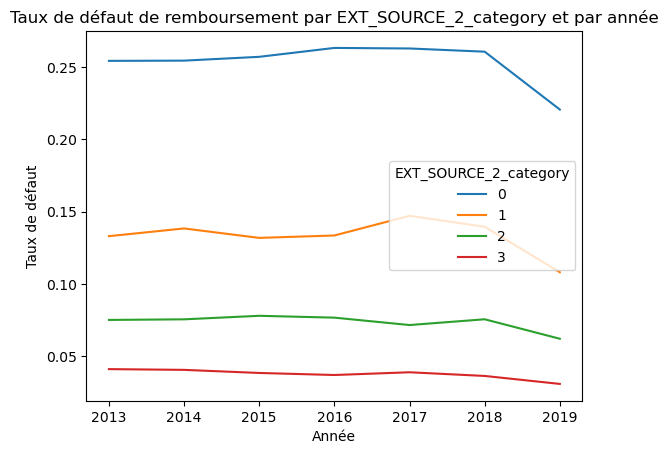

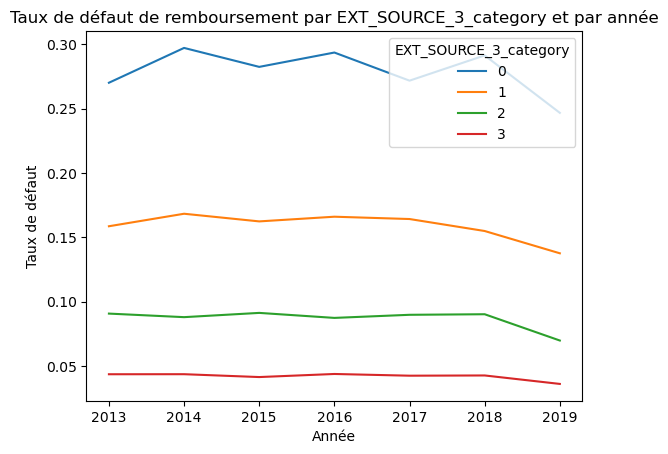

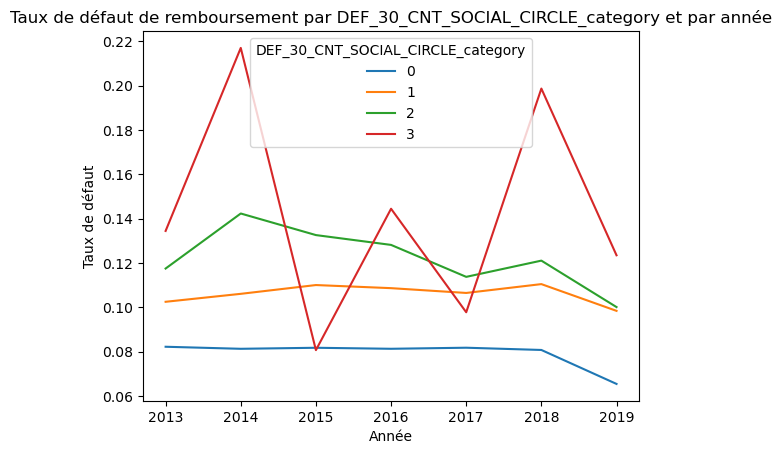

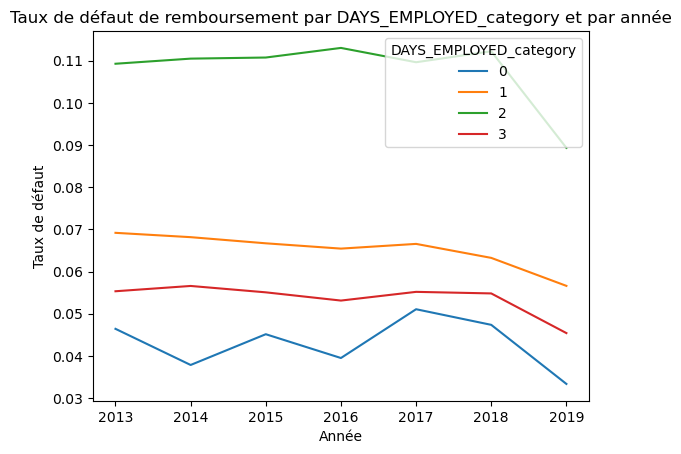

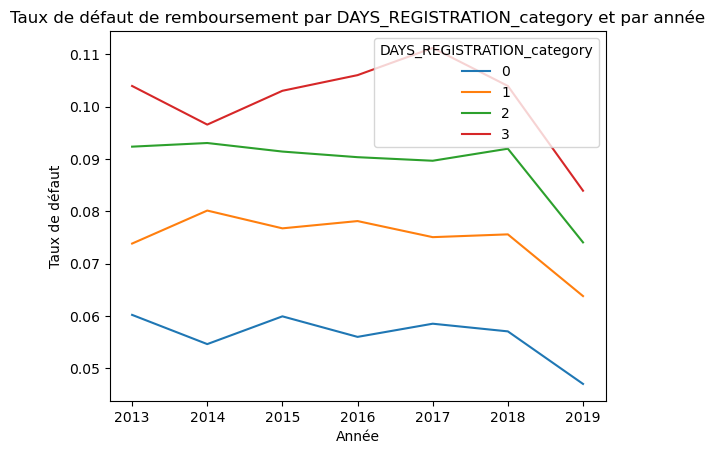

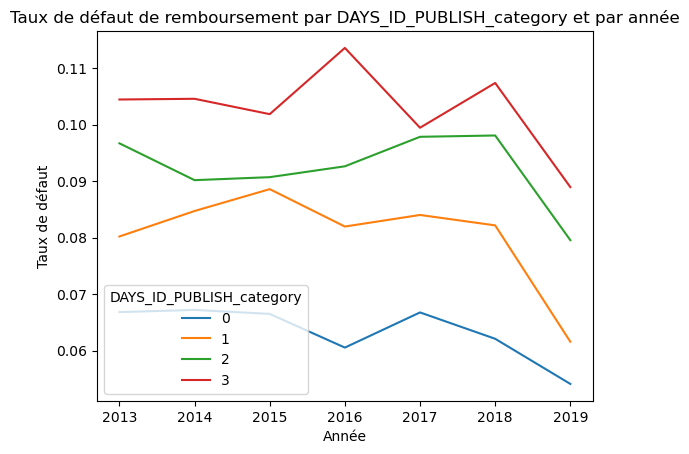

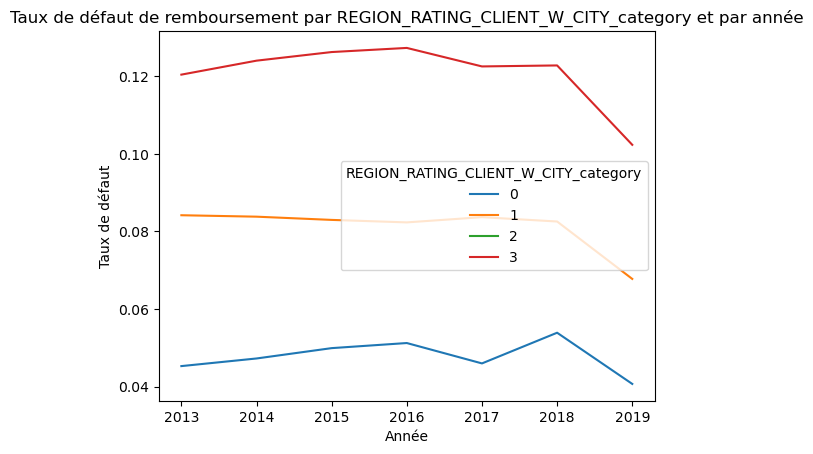

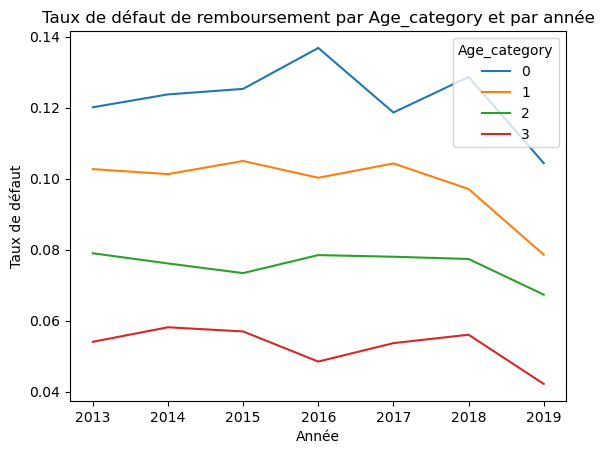

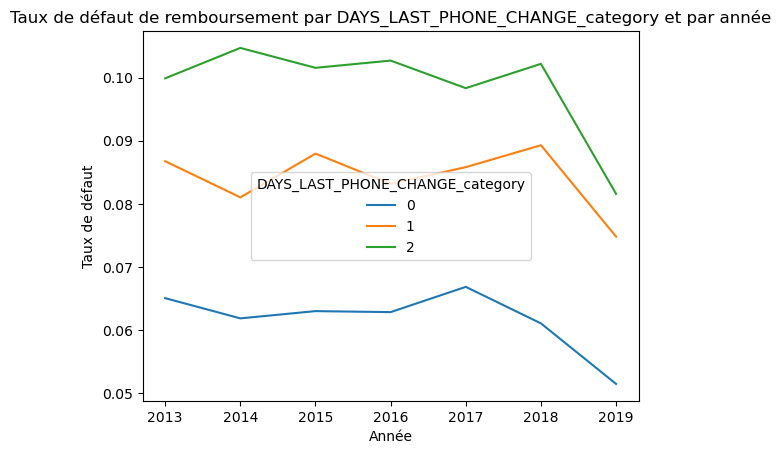

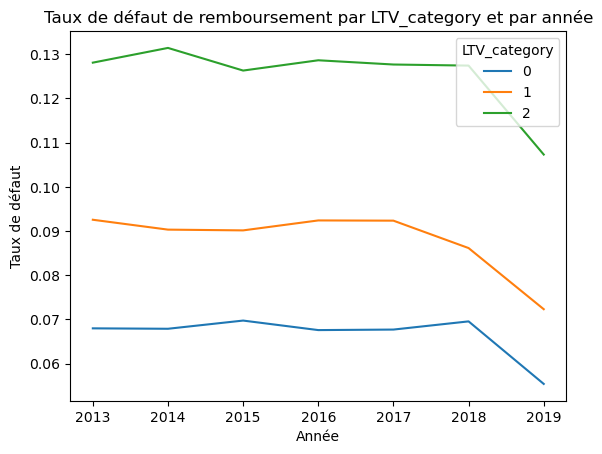

In [42]:
def calculate_default_rate(df, variable):
    defaut_par_annee_variable = df.groupby(['date_annee', variable, 'TARGET']).size().unstack().fillna(0)
    defaut_par_annee_variable = defaut_par_annee_variable.rename(columns={0: 'Non-default', 1: 'Default'})

    total_par_annee_variable = df.groupby(['date_annee', variable]).size().unstack().fillna(0)
    total_par_annee_variable = total_par_annee_variable.rename(columns={0: 'Total'})
    total_par_annee_variable['Total'] = total_par_annee_variable.sum(axis=1)

    defaut_par_annee_variable['default_rate'] = defaut_par_annee_variable['Default'] / defaut_par_annee_variable['Non-default']
    return defaut_par_annee_variable

def plot_default_rate(defaut_par_annee_variable, variable):
    defaut_par_annee_variable['default_rate'].unstack().plot(kind='line')
    plt.title('Taux de défaut de remboursement par {} et par année'.format(variable))
    plt.xlabel('Année')
    plt.ylabel('Taux de défaut')
    plt.legend(title=variable)
    plt.show()

liste_variables = var_stabile

for variable in liste_variables:
    defaut_par_annee_variable = calculate_default_rate(df, variable)
    plot_default_rate(defaut_par_annee_variable, variable)

- On remarque ici que certaines variables ne sont pas stable dans le temps et que des croisements sont présents au sein de cette dernière, nous les excluerons donc de notre analyse. 

### DF validation: variables numériques

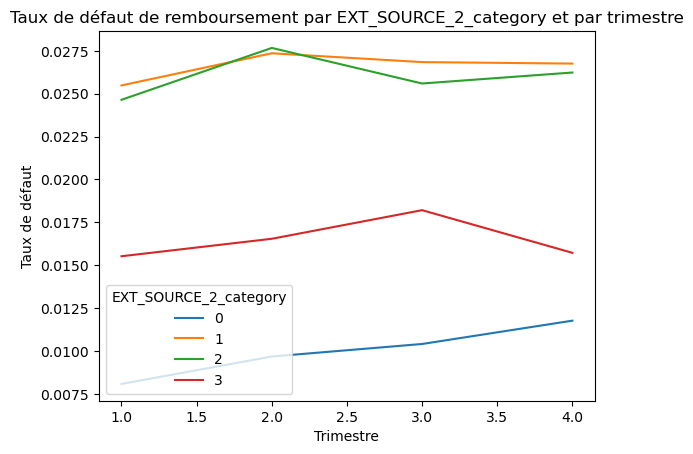

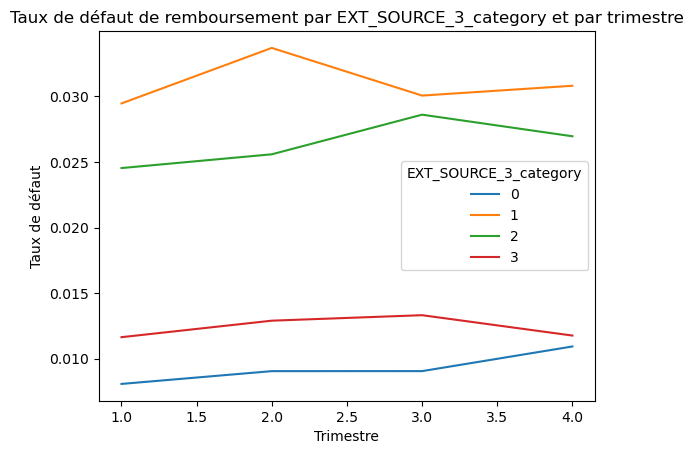

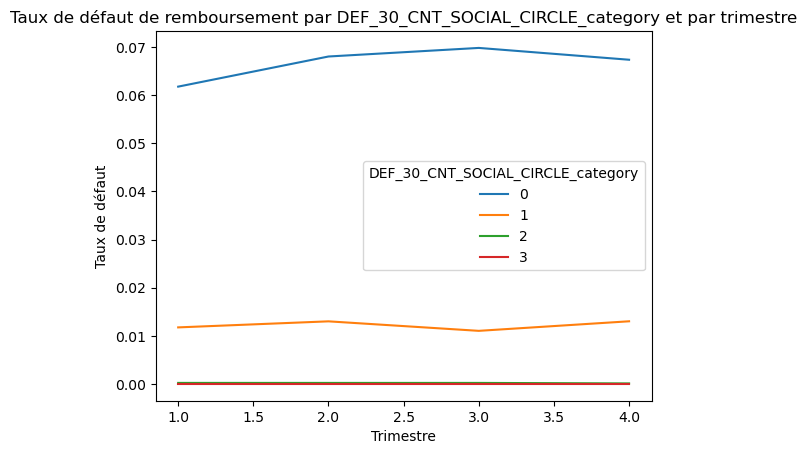

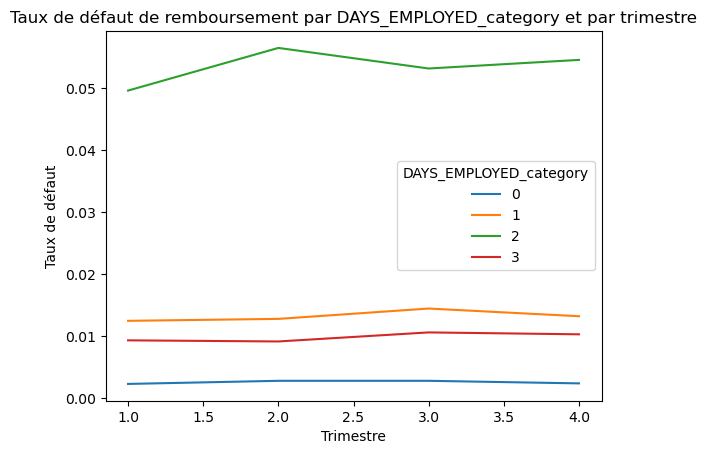

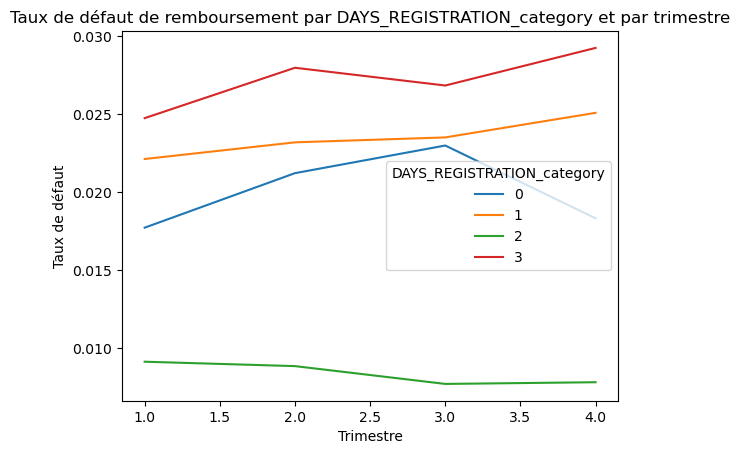

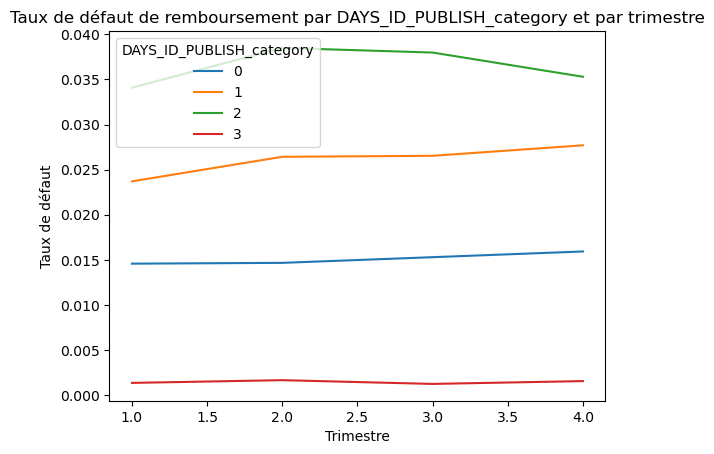

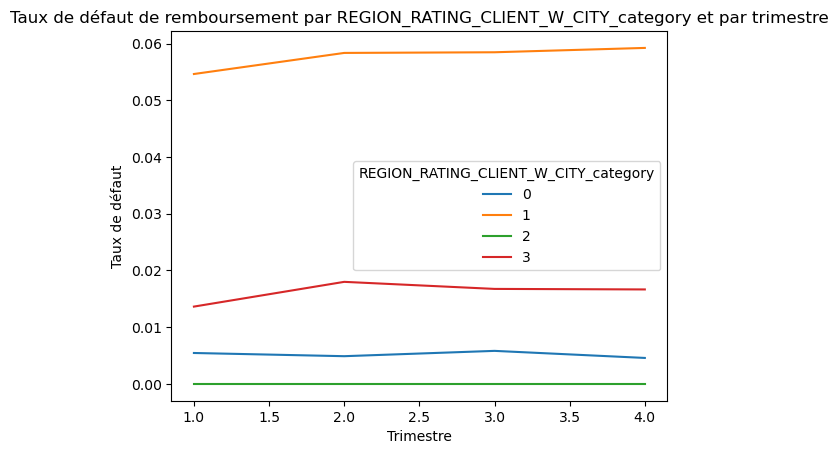

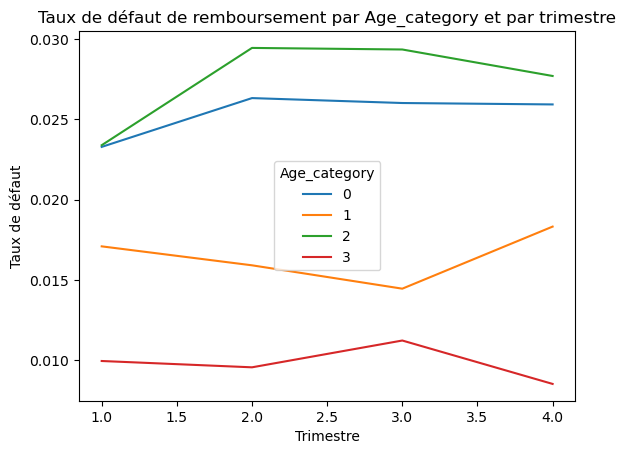

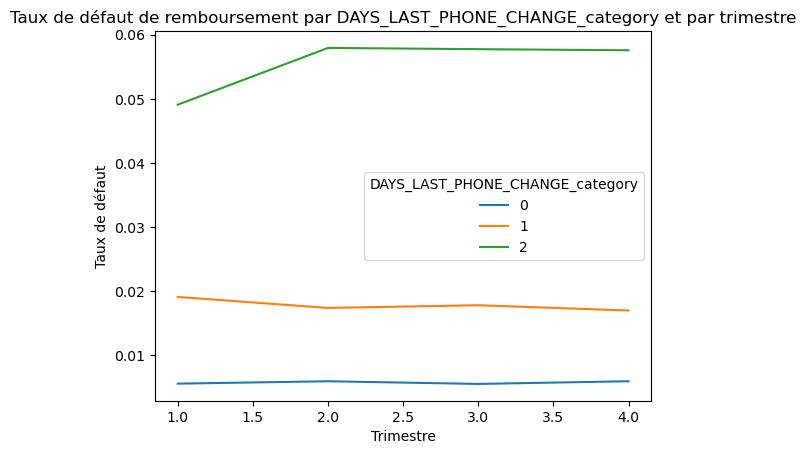

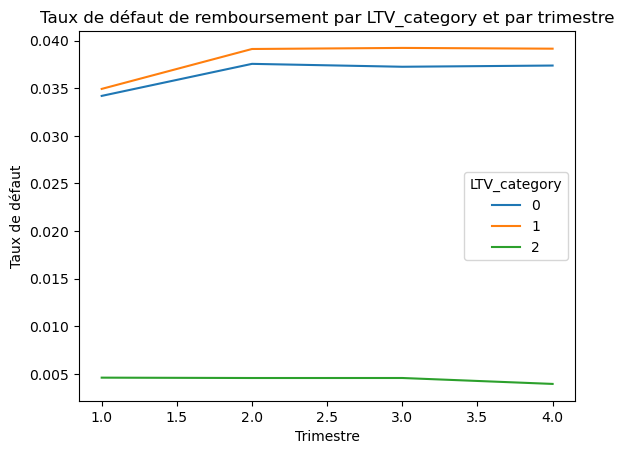

In [43]:
def calculate_default_rate(df, variable):
    defaut_par_trimestre_variable = df.groupby(['trimestre', variable, 'TARGET']).size().unstack().fillna(0)
    defaut_par_trimestre_variable = defaut_par_trimestre_variable.rename(columns={0: 'Non-default', 1: 'Default'})

    total_par_trimestre_variable = df.groupby(['trimestre', variable]).size().unstack().fillna(0)
    total_par_trimestre_variable['Total'] = total_par_trimestre_variable.sum(axis=1)

    defaut_par_trimestre_variable['default_rate'] = defaut_par_trimestre_variable['Default'] / total_par_trimestre_variable['Total']

    return defaut_par_trimestre_variable

def plot_default_rate(defaut_par_trimestre_variable, variable):
    defaut_par_trimestre_variable['default_rate'].unstack().plot(kind='line')
    plt.title('Taux de défaut de remboursement par {} et par trimestre'.format(variable))
    plt.xlabel('Trimestre')
    plt.ylabel('Taux de défaut')
    plt.legend(title=variable)
    plt.show()

df_validation['trimestre'] = df_validation['date_mensuelle'].dt.quarter

liste_variables = var_stabile

for variable in liste_variables:
    defaut_par_trimestre_variable = calculate_default_rate(df_validation, variable)
    plot_default_rate(defaut_par_trimestre_variable, variable)

- Nous remarquons que nos variables sont relativement stables dans le temps, que ce soit au niveau de la base train et dans la validation. Certaines d'entres elles se croisent dans les deux mais, comme dit au dessus, nous avons décider de les exclure de notre modèle.

### DF modélisation: variables catégorielles

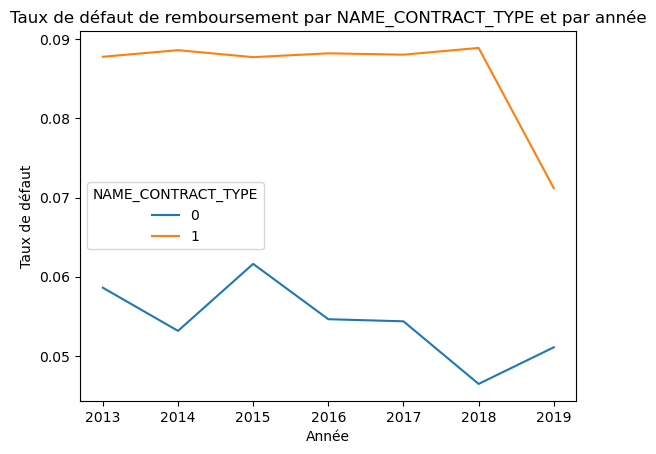

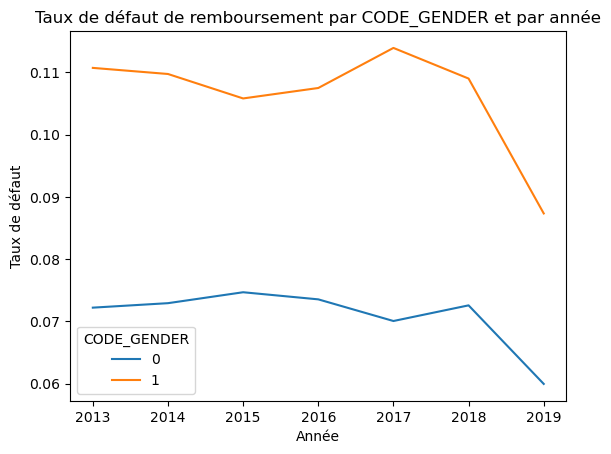

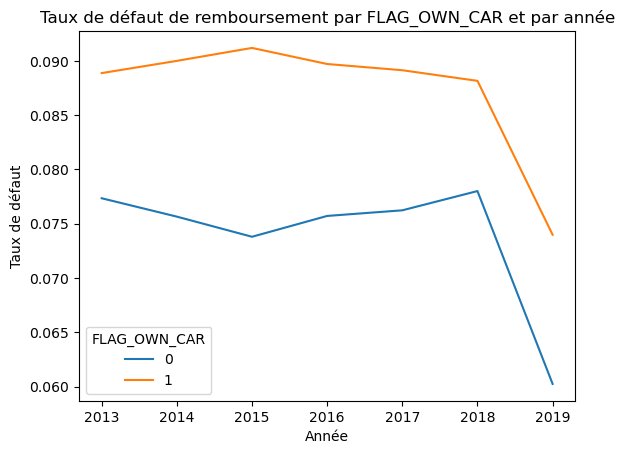

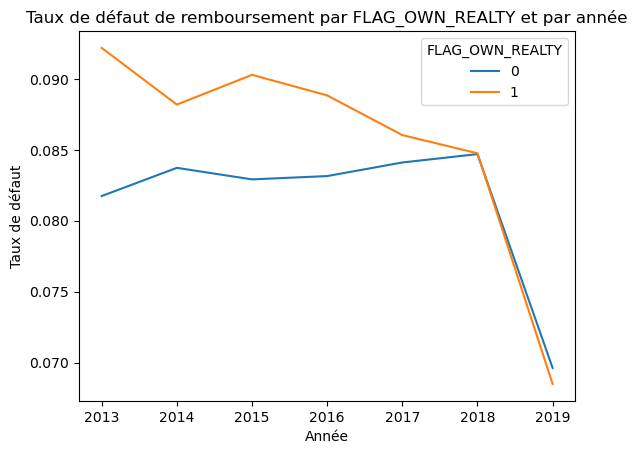

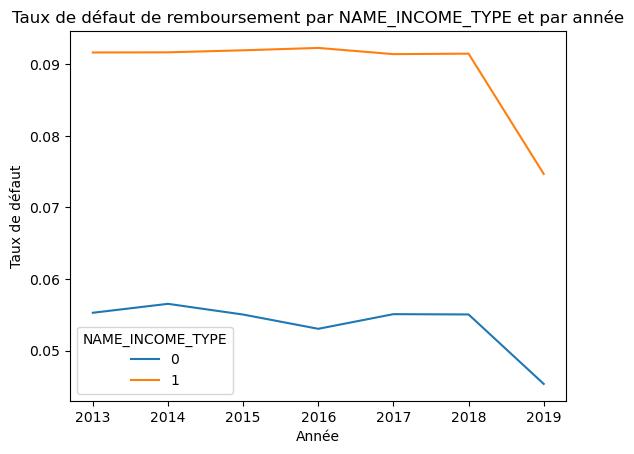

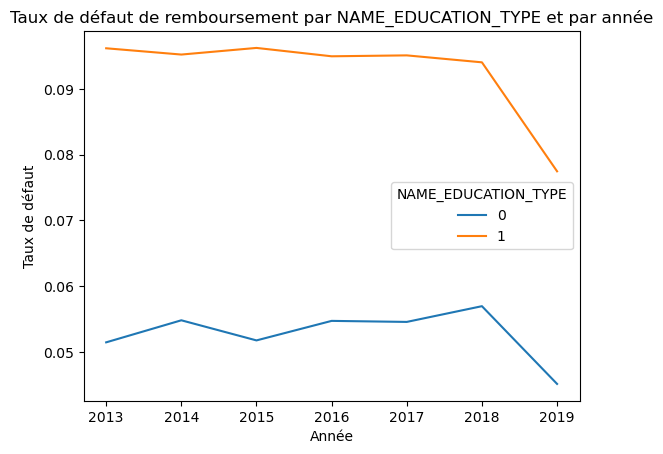

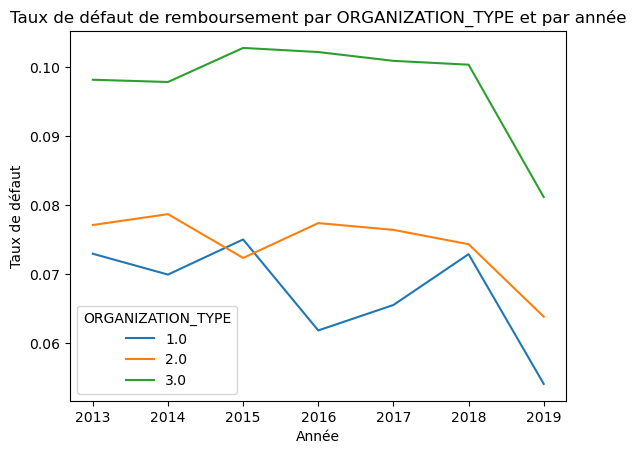

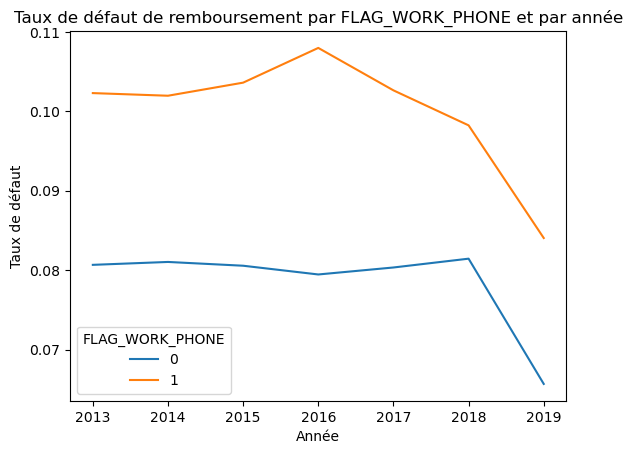

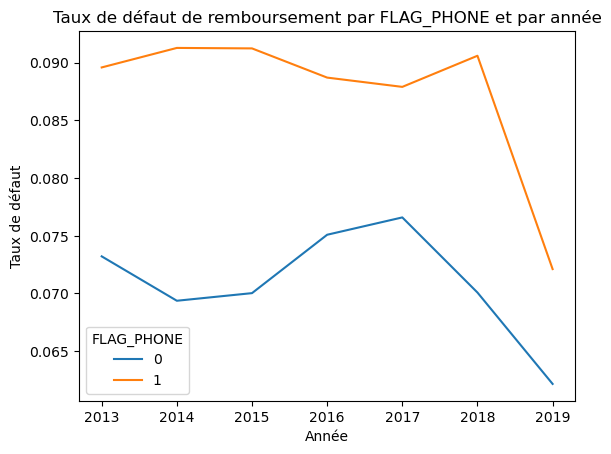

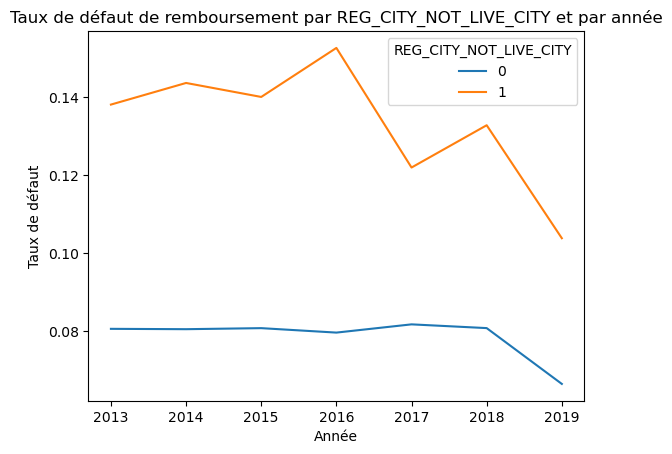

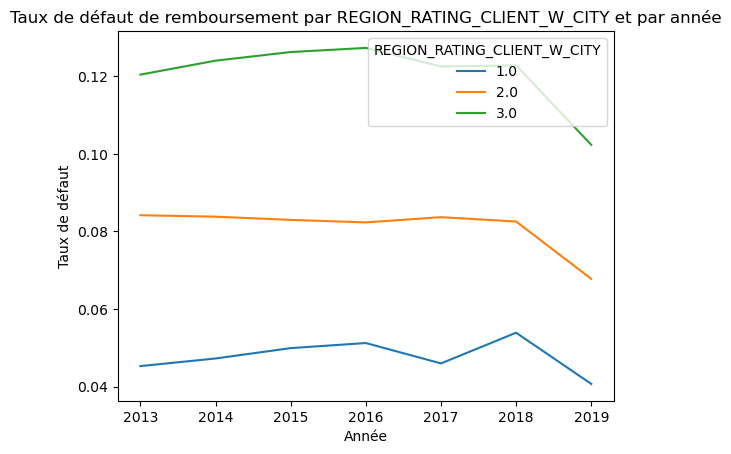

In [44]:
def calculate_default_rate(df, variable):
    defaut_par_annee_variable = df.groupby(['date_annee', variable, 'TARGET']).size().unstack().fillna(0)
    defaut_par_annee_variable = defaut_par_annee_variable.rename(columns={0: 'Non-default', 1: 'Default'})

    total_par_annee_variable = df.groupby(['date_annee', variable]).size().unstack().fillna(0)
    total_par_annee_variable = total_par_annee_variable.rename(columns={0: 'Total'})
    total_par_annee_variable['Total'] = total_par_annee_variable.sum(axis=1)

    defaut_par_annee_variable['default_rate'] = defaut_par_annee_variable['Default'] / defaut_par_annee_variable['Non-default']

    return defaut_par_annee_variable

def plot_default_rate(defaut_par_annee_variable, variable):
    defaut_par_annee_variable['default_rate'].unstack().plot(kind='line')
    plt.title('Taux de défaut de remboursement par {} et par année'.format(variable))
    plt.xlabel('Année')
    plt.ylabel('Taux de défaut')
    plt.legend(title=variable)
    plt.show()

liste_variables = columns_cat
for variable in liste_variables:
    defaut_par_annee_variable = calculate_default_rate(df, variable)
    plot_default_rate(defaut_par_annee_variable, variable)

### DF validation: variables catégorielles

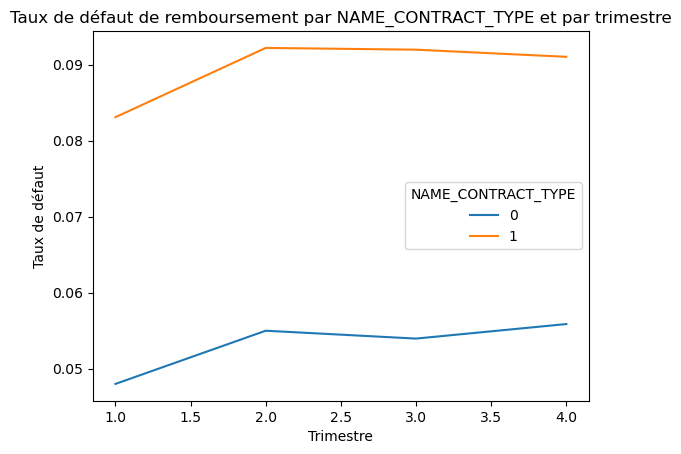

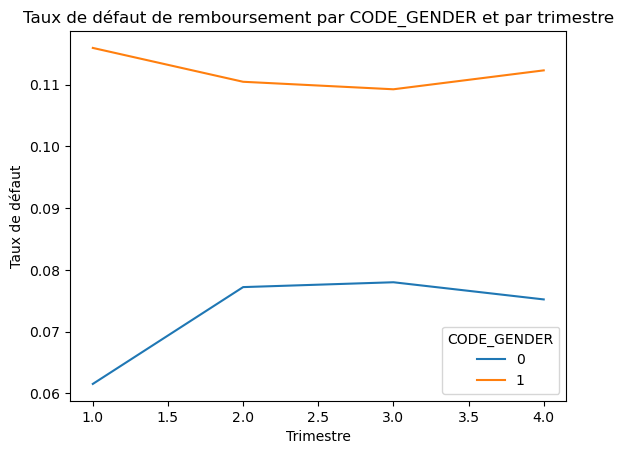

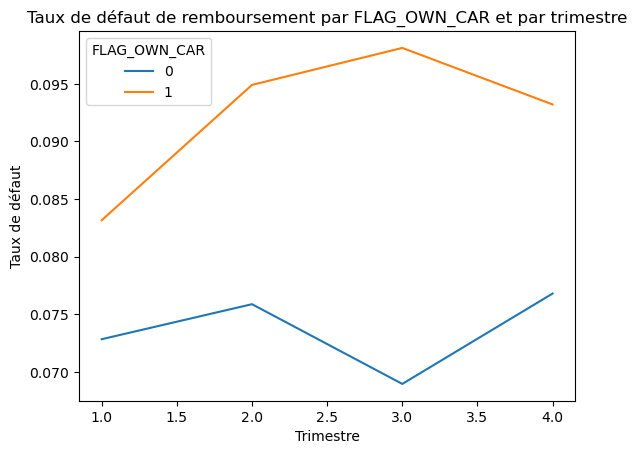

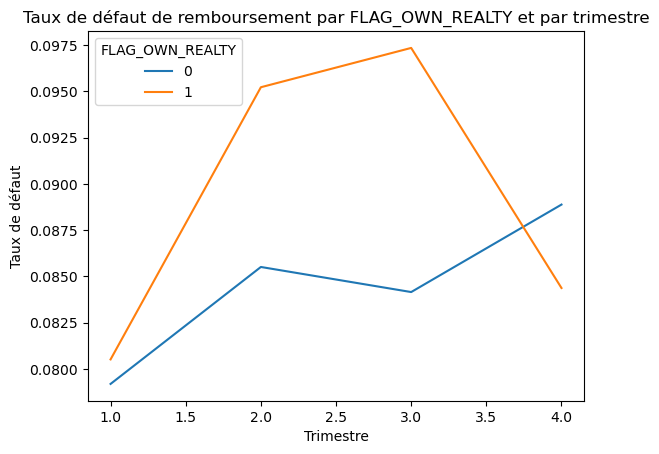

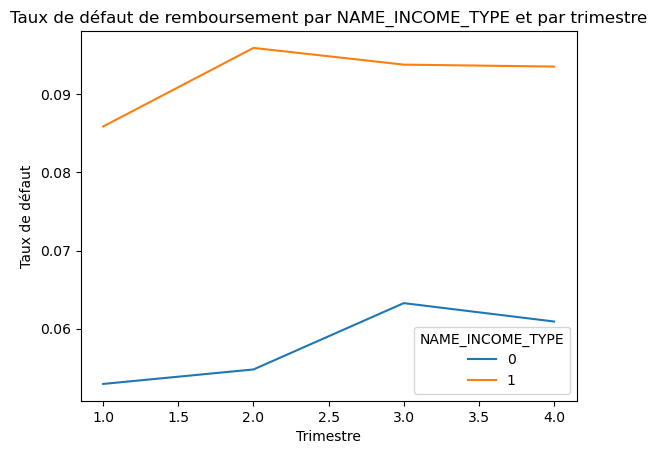

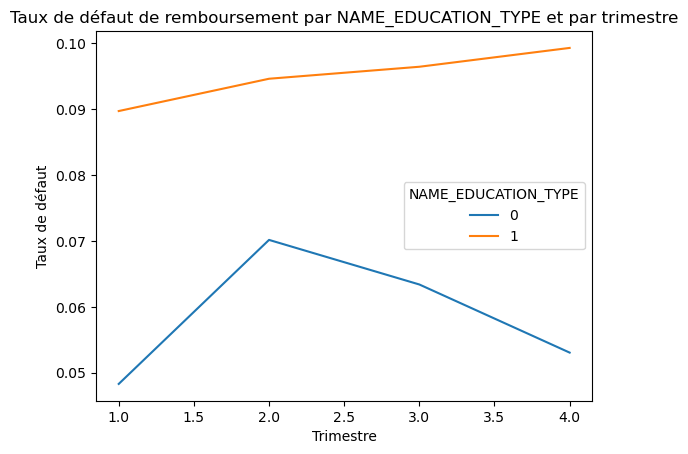

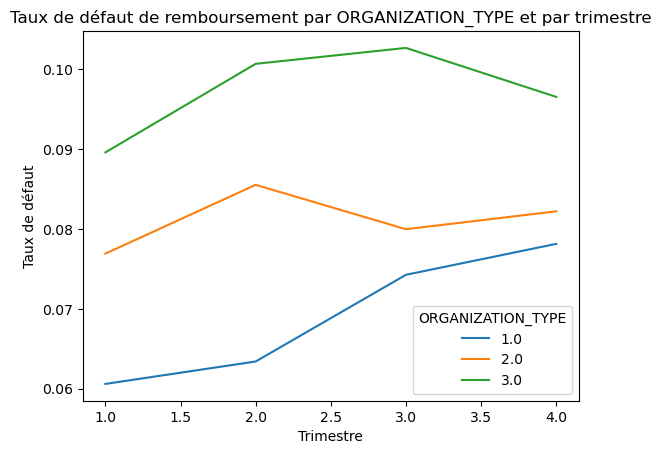

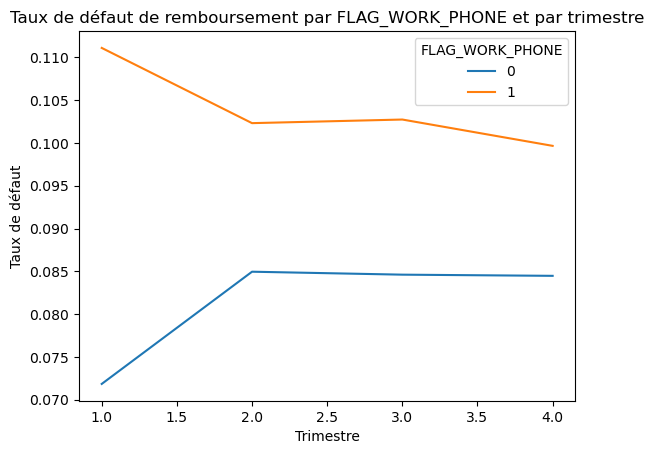

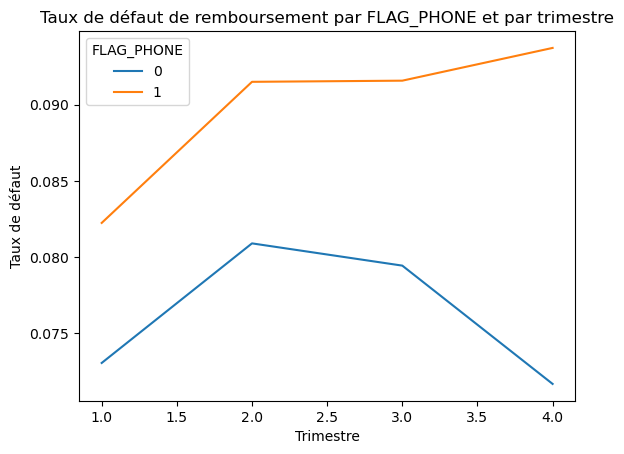

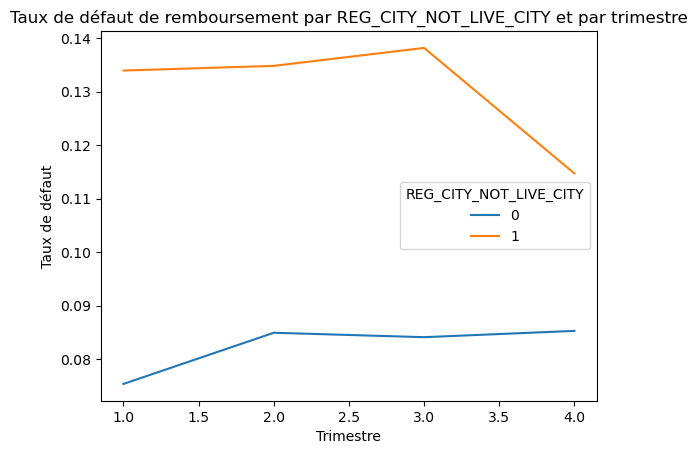

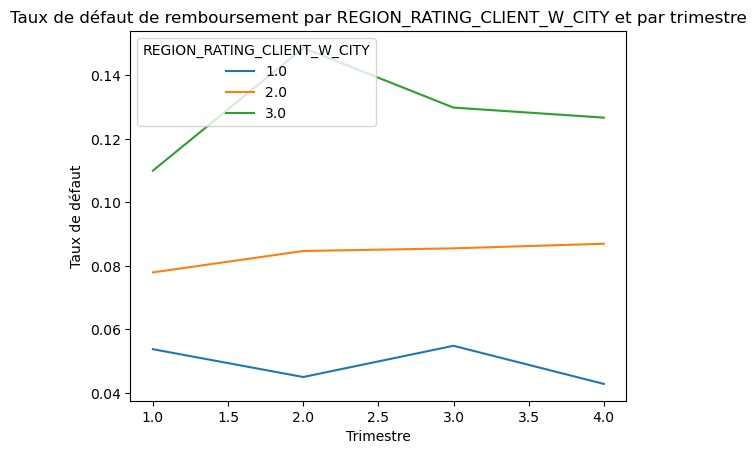

In [45]:
def calculate_default_rate(df, variable):
    defaut_par_trimestre_variable = df.groupby(['trimestre', variable, 'TARGET']).size().unstack().fillna(0)
    defaut_par_trimestre_variable = defaut_par_trimestre_variable.rename(columns={0: 'Non-default', 1: 'Default'})

    total_par_trimestre_variable = df.groupby(['trimestre', variable]).size().unstack().fillna(0)
    total_par_trimestre_variable['Total'] = total_par_trimestre_variable.sum(axis=1)

    defaut_par_trimestre_variable['default_rate'] = defaut_par_trimestre_variable['Default'] / defaut_par_trimestre_variable['Non-default']

    return defaut_par_trimestre_variable

def plot_default_rate(defaut_par_trimestre_variable, variable):
    defaut_par_trimestre_variable['default_rate'].unstack().plot(kind='line')
    plt.title('Taux de défaut de remboursement par {} et par trimestre'.format(variable))
    plt.xlabel('Trimestre')
    plt.ylabel('Taux de défaut')
    plt.legend(title=variable)
    plt.show()

liste_variables = columns_cat

for variable in liste_variables:
    defaut_par_annee_variable = calculate_default_rate(df_validation, variable)
    plot_default_rate(defaut_par_annee_variable, variable)

## En effectif:

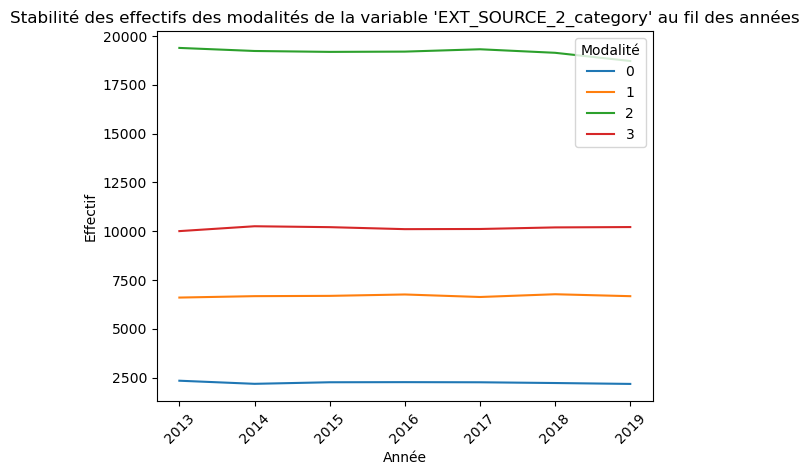

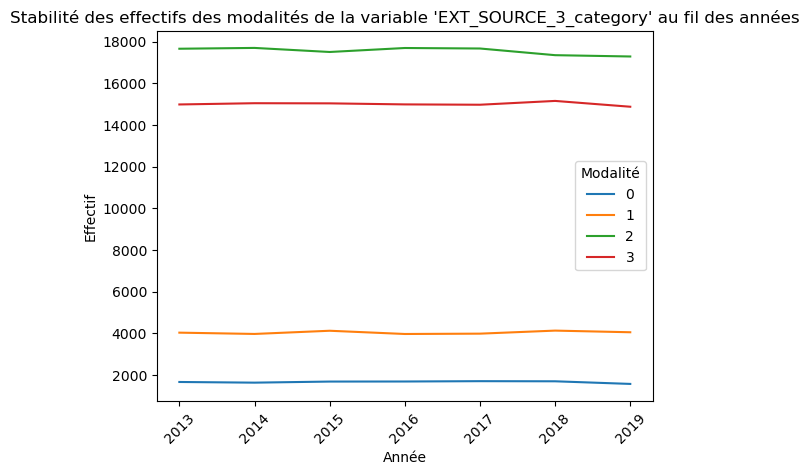

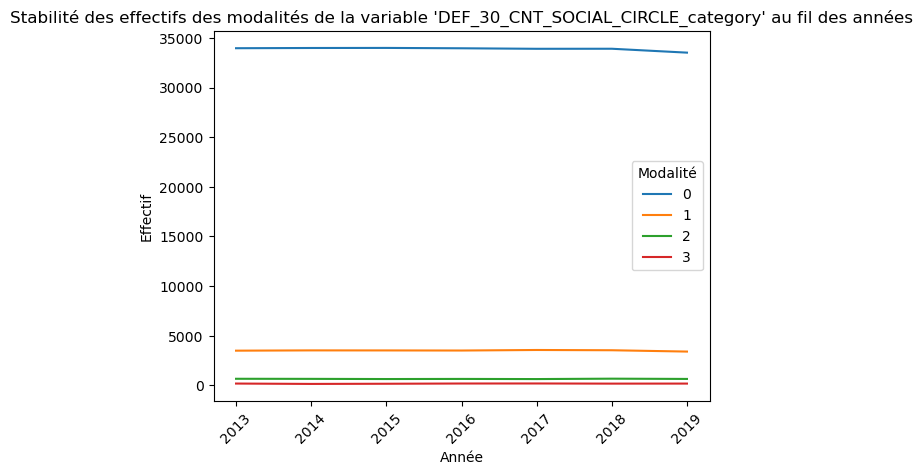

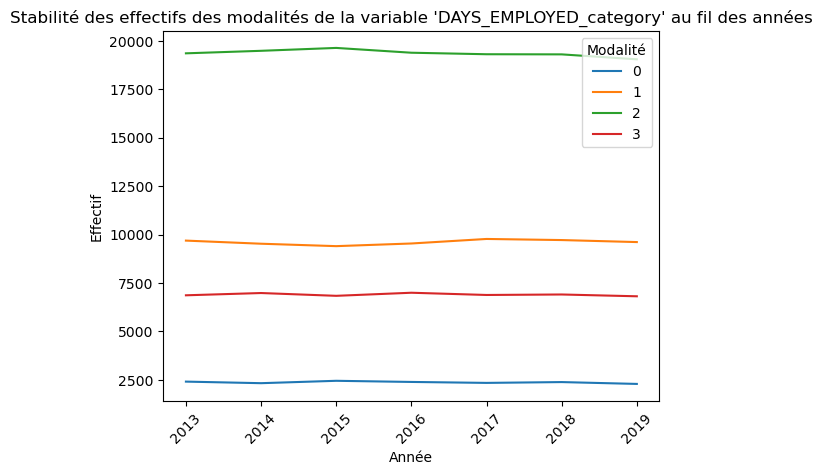

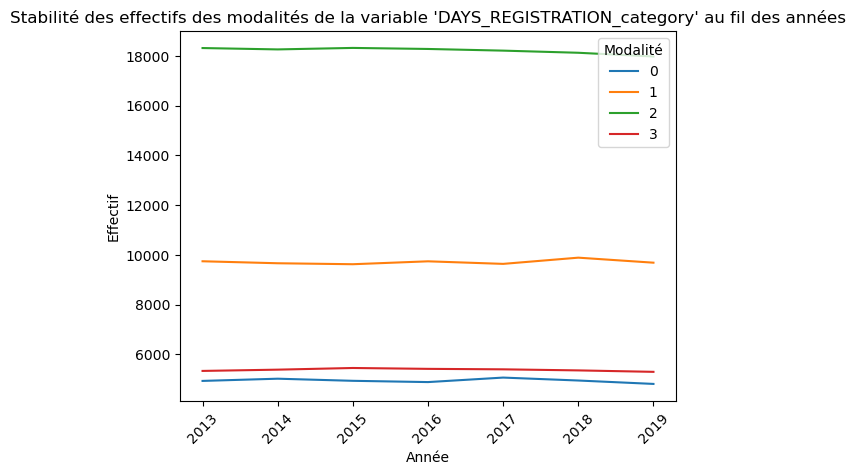

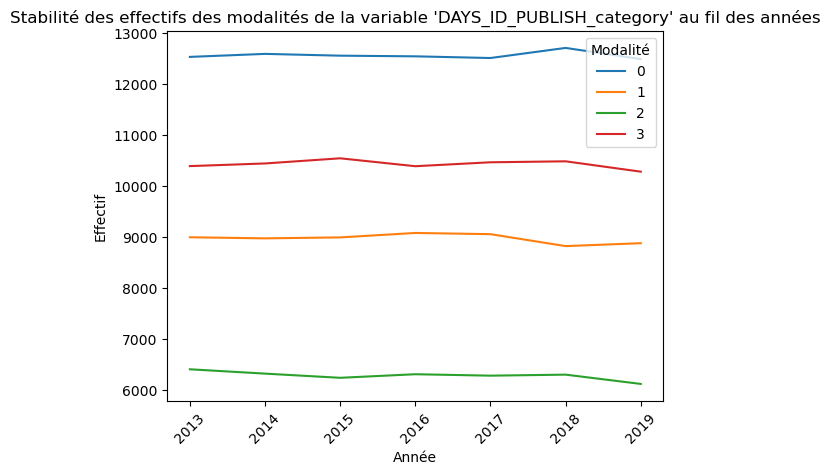

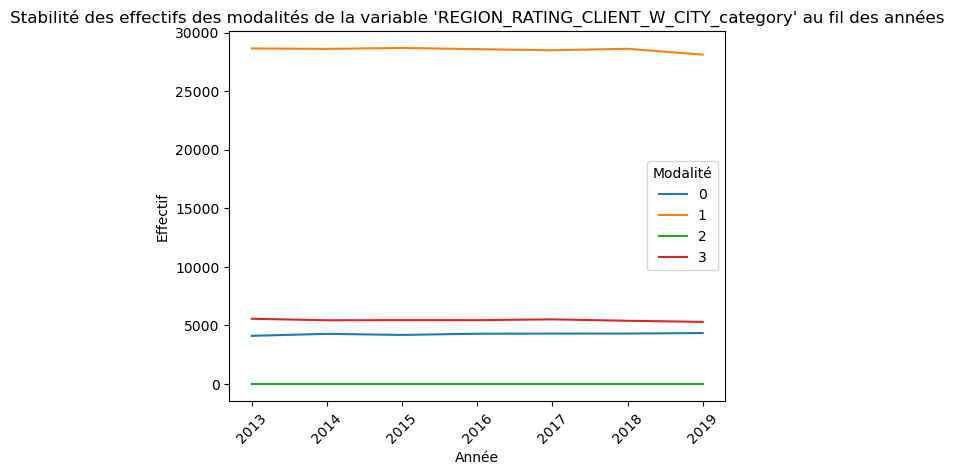

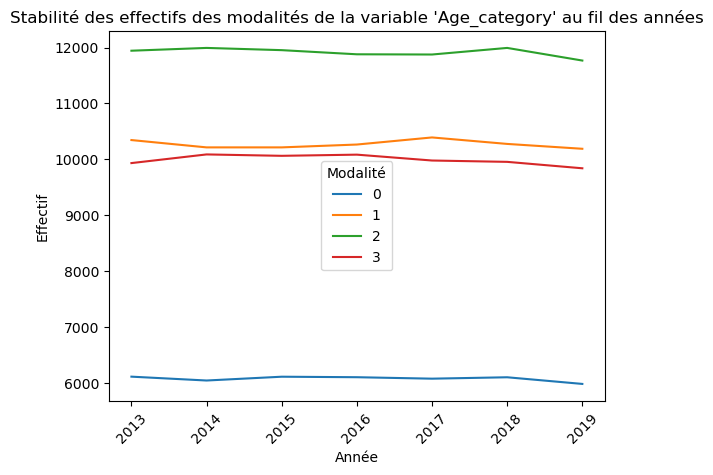

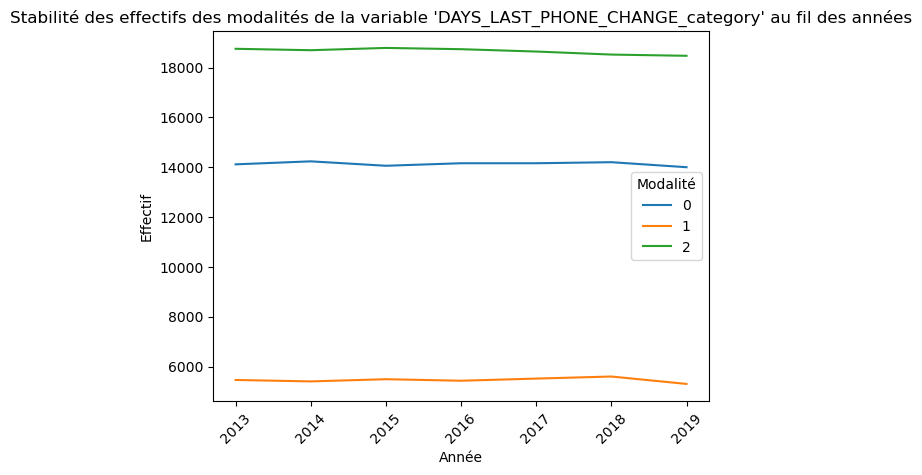

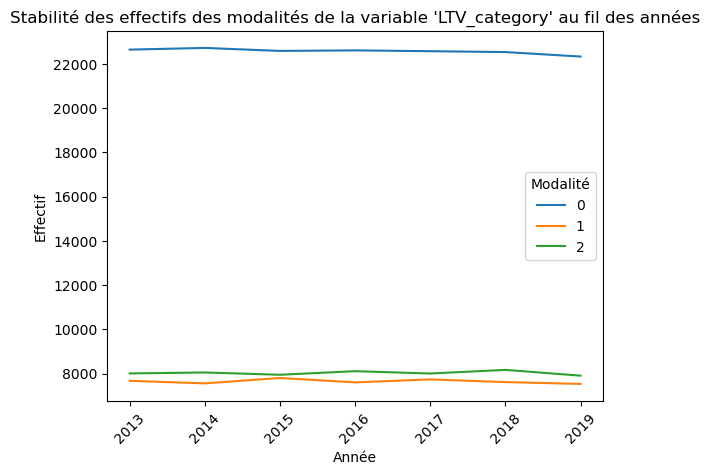

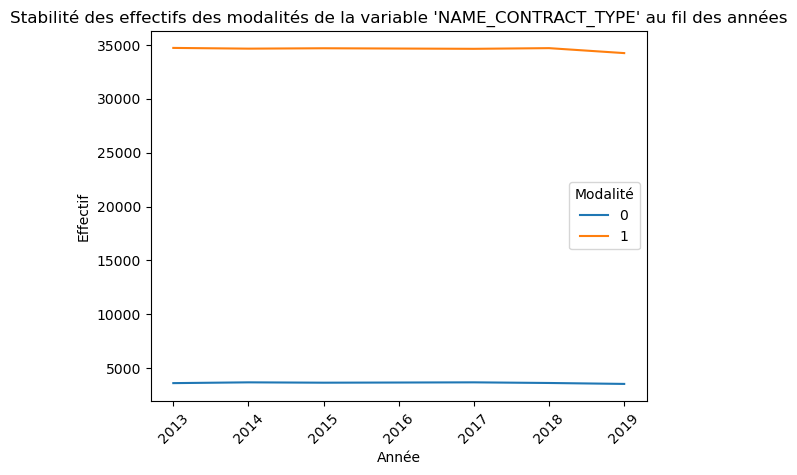

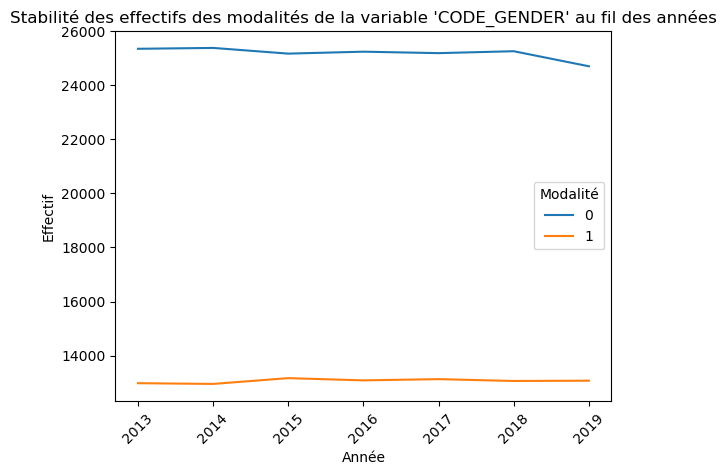

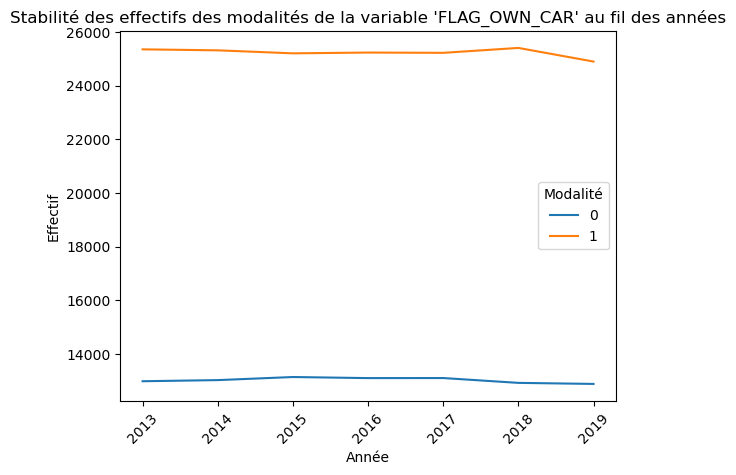

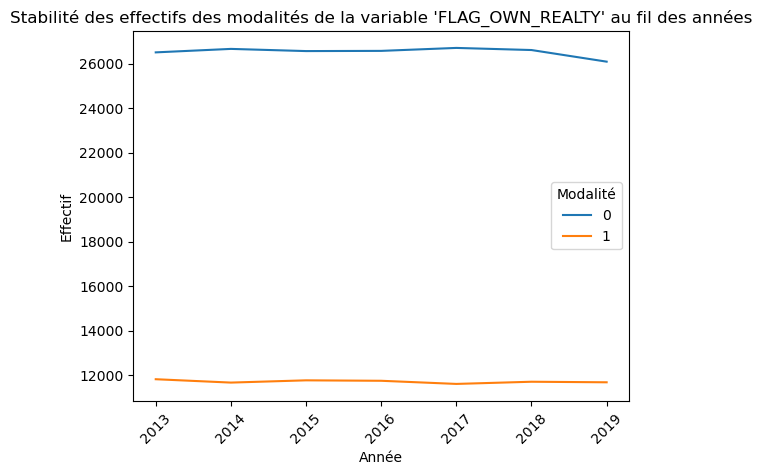

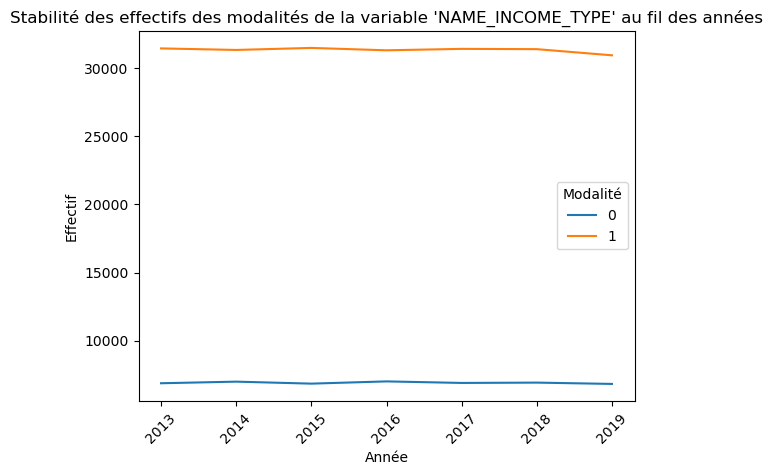

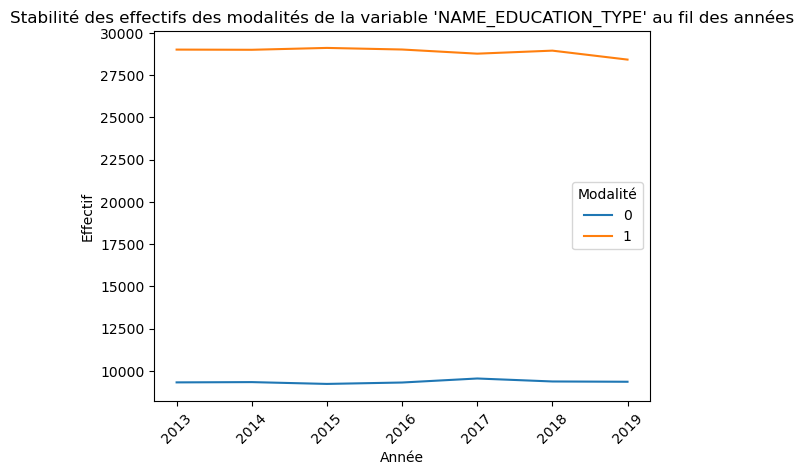

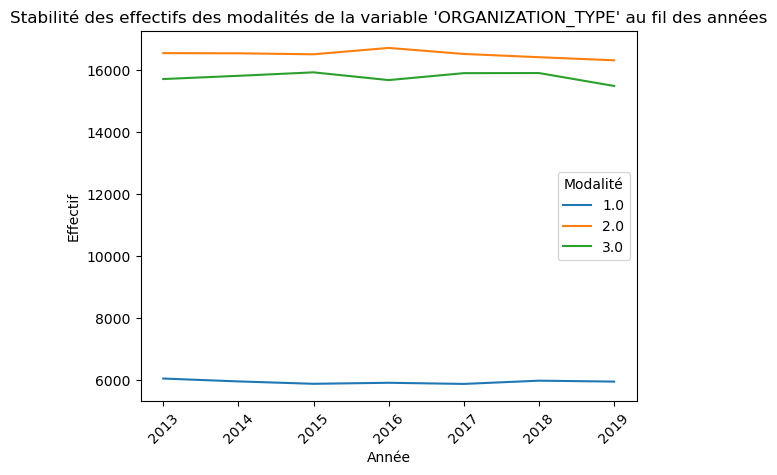

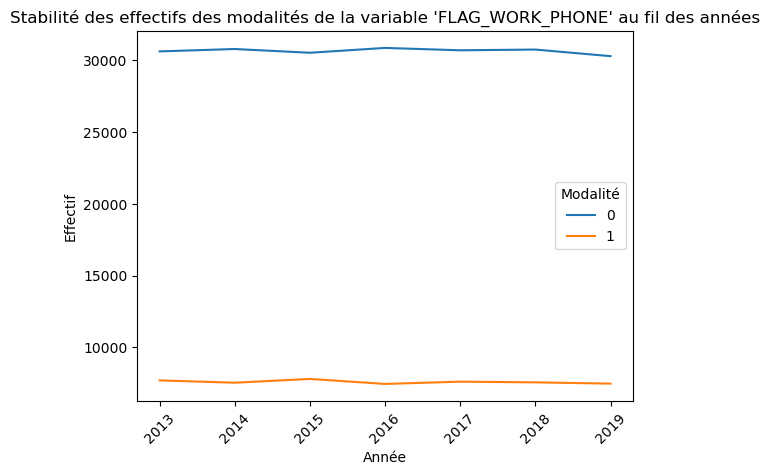

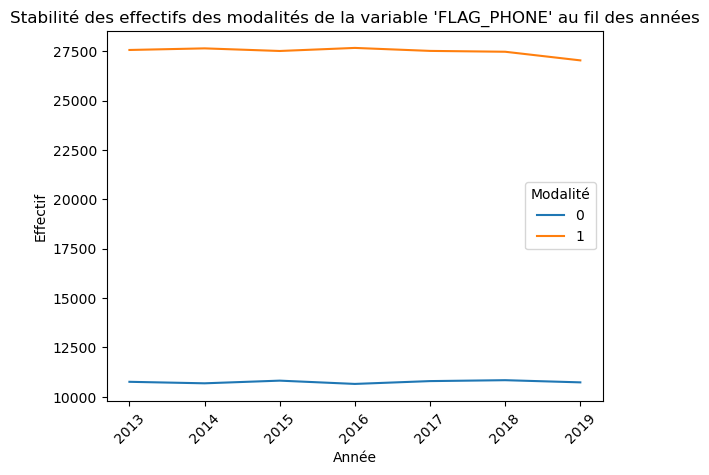

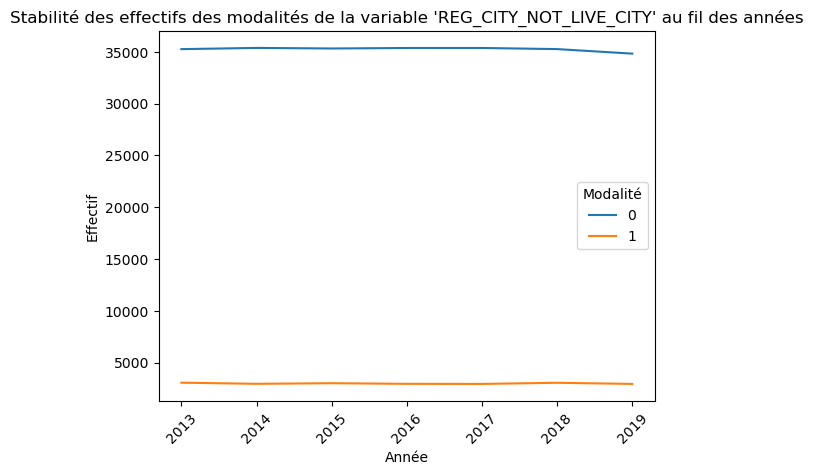

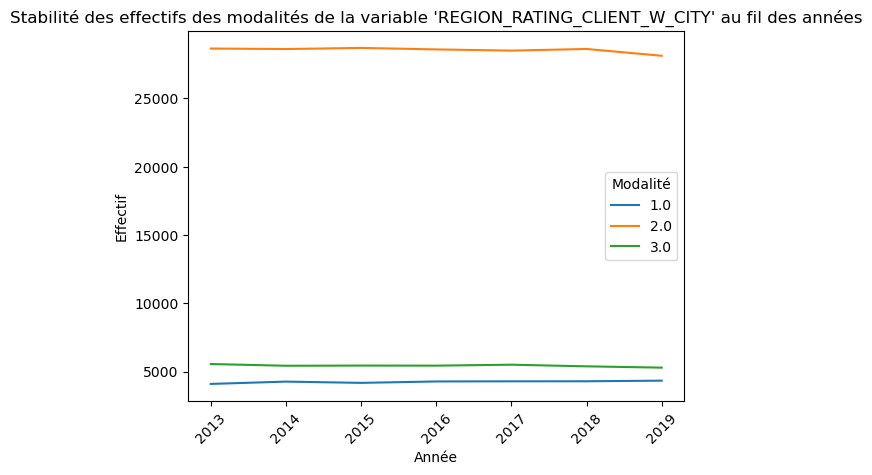

In [46]:
def plot_grouped_data(df, groups):
    for group in groups:
        groupe = df.groupby(['date_annee', group]).size().unstack()
        groupe = groupe.fillna(0)
        groupe.plot(kind='line')
        plt.title(f"Stabilité des effectifs des modalités de la variable '{group}' au fil des années")
        plt.xlabel('Année')
        plt.ylabel('Effectif')
        plt.legend(title='Modalité')
        plt.xticks(rotation=45)
        plt.show()

groups = var_stabile + columns_cat

plot_grouped_data(df, groups)

## Vérification condition: plus de 5% dans chaque class

In [47]:
def check_modalities_percentage(df, quali):
    for col in df[quali]:
        modalities_percentage = df[col].value_counts(normalize=True) * 100

        for modality, percentage in modalities_percentage.items():
            if percentage < 5:
                print(f"La modalité '{modality}' de la colonne '{col}' a moins de 5% de la population ({percentage:.2f}%)")

In [48]:
check_modalities_percentage(df_validation, var_stabile)

La modalité '0' de la colonne 'EXT_SOURCE_2_category' a moins de 5% de la population (4.14%)
La modalité '0' de la colonne 'EXT_SOURCE_3_category' a moins de 5% de la population (3.84%)
La modalité '2' de la colonne 'DEF_30_CNT_SOCIAL_CIRCLE_category' a moins de 5% de la population (0.09%)
La modalité '3' de la colonne 'DEF_30_CNT_SOCIAL_CIRCLE_category' a moins de 5% de la population (0.01%)
La modalité '3' de la colonne 'DAYS_ID_PUBLISH_category' a moins de 5% de la population (1.06%)
La modalité '2' de la colonne 'REGION_RATING_CLIENT_W_CITY_category' a moins de 5% de la population (0.00%)
La modalité '2' de la colonne 'LTV_category' a moins de 5% de la population (2.87%)


- Certaines modalités concernent moins de 5% de la population. Pour régler ce problème de proportion, nous avons décidé de regrouper les modalités avec peu d'effectif avec la modalité la plus similaire de sa variable. Après ce travail de regroupement, nous nous sommes assurés que cette modification n'impactait pas la stabilité en risque fait ci-dessus.

In [49]:
df['EXT_SOURCE_3_category'].replace({1: 0}, inplace=True)
df_validation['EXT_SOURCE_3_category'].replace({1: 0}, inplace=True)

df['REGION_RATING_CLIENT_W_CITY_category'].replace({2: 0}, inplace=True)
df_validation['REGION_RATING_CLIENT_W_CITY_category'].replace({2: 0}, inplace=True)

In [50]:
check_modalities_percentage(df, groups) # à supprimer

La modalité '2' de la colonne 'DEF_30_CNT_SOCIAL_CIRCLE_category' a moins de 5% de la population (1.73%)
La modalité '3' de la colonne 'DEF_30_CNT_SOCIAL_CIRCLE_category' a moins de 5% de la population (0.49%)


# Sélection de variable par StepWise :


La sélection de variables par Stepwise est une technique itérative couramment utilisée en risque de crédit pour identifier nos variables les plus impactantes. Ce processus utilise les méthodes backward et forward : elle élimine progressivement les variables moins importantes tout en ajoutant celles qui améliorent la qualité de l'ajustement du modèle, généralement mesurée par des critères d'information comme l'AIC ou le BIC. 

Dans notre cas, le critère de Wald à été choisi. Le critère de Wald est basé sur le rapport entre le carré de l'estimateur du coefficient d'une variable et sa variance. Plus précisément, il teste l'hypothèse nulle selon laquelle ce coefficient est égal à zéro, ce qui signifierait que la variable n'a pas d'effet significatif sur la variable cible. Si le rapport de Wald est suffisamment élevé, l'hypothèse nulle est rejetée, indiquant ainsi que la variable est significative pour le modèle. 

En itérant entre l'ajout et la suppression de variables, la méthode vise à créer un modèle simple et interprétable tout en maintenant une performance prédictive élevée. Ce processus permet de capturer les relations linéaires entre les variables explicatives et la variable cible.

In [51]:
df_selection = df.drop(['EXT_SOURCE_2', 'DEF_30_CNT_SOCIAL_CIRCLE', 'FLAG_OWN_REALTY', 'ORGANIZATION_TYPE',
                        'DAYS_LAST_PHONE_CHANGE','LTV', 'EXT_SOURCE_2_category', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE_category',
                        'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT_W_CITY', 'Age',
                        'date_mensuelle','date_annee'], axis=1)

X = df_selection.drop(columns=['TARGET'])
y = df_selection['TARGET']
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.01):
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

selected_features = stepwise_selection(X, y)
print('Selected features:', selected_features)

Add  EXT_SOURCE_3_category          with p-value 0.0
Add  LTV_category                   with p-value 1.99096e-258
Add  NAME_EDUCATION_TYPE            with p-value 6.97297e-175
Add  Age_category                   with p-value 1.80865e-191
Add  REGION_RATING_CLIENT_W_CITY_category with p-value 4.38308e-148
Add  CODE_GENDER                    with p-value 6.55089e-105
Add  DAYS_LAST_PHONE_CHANGE_category with p-value 2.0298e-87
Add  FLAG_OWN_CAR                   with p-value 9.32369e-73
Add  NAME_CONTRACT_TYPE             with p-value 1.99577e-27
Add  DAYS_EMPLOYED_category         with p-value 1.51711e-25
Add  NAME_INCOME_TYPE               with p-value 9.34226e-71
Add  FLAG_WORK_PHONE                with p-value 7.98633e-20
Add  REG_CITY_NOT_LIVE_CITY         with p-value 1.95666e-15
Add  DAYS_ID_PUBLISH_category       with p-value 1.38962e-14
Add  FLAG_PHONE                     with p-value 7.466e-13
Add  DAYS_REGISTRATION_category     with p-value 7.64717e-10
Selected features: ['EX

Comme dit au dessus, cette fonction sélectionne les variables en utilisant le critère d'arrêt Wald, basée sur les p-values obtenues à partir du modèle de régression logistique de `statsmodels.api.Logit`. 

Elle prend en entrée un DataFrame pandas `X` contenant les variables candidates ainsi notre variable cible. Deux seuils sont définis : `seuil_in` et `seuil_out`. 

La variable est sélectionnée si sa valeur de p est inférieure au seuil `seuil_in`, et exclue si sa valeur de p est supérieure au seuil `seuil_out`. La fonction retourne la liste des variable sélectionnées.

## Variables finalement retenues:

Du fait des pré-selections faites avant et après la discrétisation, toutes les variables du modèle sont significatives. Le choix des variables de notre modèle s'est donc fait par rapport aux varibles avec les p-value les plus basses.

In [52]:
df_fin = df_selection[['EXT_SOURCE_3_category', 'LTV_category', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'Age_category', 'REGION_RATING_CLIENT_W_CITY_category', 'TARGET']]
df_fin_val = df_validation[['EXT_SOURCE_3_category', 'LTV_category', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'Age_category', 'REGION_RATING_CLIENT_W_CITY_category', 'TARGET']]

## Régression logistique :

Les résultats ce-dessous sont fait de manière simultanié sur la base principale et la base de validation afin de s'assurer de la fiabilité de nos résultats :  

#### 1. Ordonner les modalités de manière croissante en fonction du taux de défaut :

In [53]:
rank_col = [col for col in df_fin_val.columns if df_fin_val[col].nunique() >= 3]

for var in rank_col:
  bin_positive_proportion = df_fin_val.groupby(var)['TARGET'].mean()
  df_fin_val[var] = df_fin_val[var].map(bin_positive_proportion.rank(ascending=True))
    
for var in rank_col:
  bin_positive_proportion = df_fin.groupby(var)['TARGET'].mean()
  df_fin[var] = df_fin[var].map(bin_positive_proportion.rank(ascending=True))

#### 2. Création des modalités de référence pour chacune de nos variables :

In [54]:
# Sur DF
X = df_fin.drop('TARGET',axis=1)
y= df_fin.TARGET
encoded_data = dmatrix("C(LTV_category, Treatment(reference=1)) + C(Age_category, Treatment(reference=1)) + C(REGION_RATING_CLIENT_W_CITY_category, Treatment(reference=1)) + C(EXT_SOURCE_3_category, Treatment(reference=1)) + C(CODE_GENDER, Treatment(reference=0)) + C(NAME_EDUCATION_TYPE, Treatment(reference=0))",
                       X, return_type='dataframe')
encoded_data

,Intercept,"C(LTV_category, Treatment(reference=1))[T.2.0]","C(LTV_category, Treatment(reference=1))[T.3.0]","C(Age_category, Treatment(reference=1))[T.4.0]","C(Age_category, Treatment(reference=1))[T.3.0]","C(Age_category, Treatment(reference=1))[T.2.0]","C(REGION_RATING_CLIENT_W_CITY_category, Treatment(reference=1))[T.2.0]","C(REGION_RATING_CLIENT_W_CITY_category, Treatment(reference=1))[T.3.0]","C(EXT_SOURCE_3_category, Treatment(reference=1))[T.3.0]","C(EXT_SOURCE_3_category, Treatment(reference=1))[T.2.0]","C(CODE_GENDER, Treatment(reference=0))[T.1]","C(NAME_EDUCATION_TYPE, Treatment(reference=0))[T.1]"
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
267738,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
267739,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
267740,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
267741,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [55]:
# DF_VAL
X_val = df_fin_val.drop('TARGET',axis=1)
y_val = df_fin_val.TARGET
encoded_data_val = dmatrix("C(LTV_category, Treatment(reference=1)) + C(Age_category, Treatment(reference=1)) + C(REGION_RATING_CLIENT_W_CITY_category, Treatment(reference=1)) + C(EXT_SOURCE_3_category, Treatment(reference=1)) + C(CODE_GENDER, Treatment(reference=0)) + C(NAME_EDUCATION_TYPE, Treatment(reference=0))",
                       X_val, return_type='dataframe')

encoded_data_val

,Intercept,"C(LTV_category, Treatment(reference=1))[T.2.0]","C(LTV_category, Treatment(reference=1))[T.3.0]","C(Age_category, Treatment(reference=1))[T.4.0]","C(Age_category, Treatment(reference=1))[T.3.0]","C(Age_category, Treatment(reference=1))[T.2.0]","C(REGION_RATING_CLIENT_W_CITY_category, Treatment(reference=1))[T.2.0]","C(REGION_RATING_CLIENT_W_CITY_category, Treatment(reference=1))[T.3.0]","C(EXT_SOURCE_3_category, Treatment(reference=1))[T.3.0]","C(EXT_SOURCE_3_category, Treatment(reference=1))[T.2.0]","C(CODE_GENDER, Treatment(reference=0))[T.1]","C(NAME_EDUCATION_TYPE, Treatment(reference=0))[T.1]"
267743,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
267744,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
267745,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
267746,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
267747,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
306102,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
306103,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
306104,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
306105,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


## Modèle LOGIT : analyse des coefficients 

#### DF modélisation: 

In [56]:
logit_model = sm.Logit(y, encoded_data)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.251991
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               267739
Model:                          Logit   Df Residuals:                   267727
Method:                           MLE   Df Model:                           11
Date:                Wed, 28 Feb 2024   Pseudo R-squ.:                 0.06605
Time:                        16:32:30   Log-Likelihood:                -67468.
converged:                       True   LL-Null:                       -72239.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------

#### Sur la validation :

In [57]:
logit_model = sm.Logit(y_val, encoded_data_val)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.258677
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:                38364
Model:                          Logit   Df Residuals:                    38352
Method:                           MLE   Df Model:                           11
Date:                Wed, 28 Feb 2024   Pseudo R-squ.:                 0.06499
Time:                        16:32:31   Log-Likelihood:                -9923.9
converged:                       True   LL-Null:                       -10614.
Covariance Type:            nonrobust   LLR p-value:                3.258e-289
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------

In [58]:
coefficients = result.params
odds_ratios = np.exp(coefficients)
odds_ratios_df = pd.DataFrame({'Variable': coefficients.index, 'Coefficient': coefficients.values, 'Odds Ratio': odds_ratios.values})
print(odds_ratios_df)

                                             Variable  Coefficient  Odds Ratio
0                                           Intercept    -4.747943    0.008670
1      C(LTV_category, Treatment(reference=1))[T.2.0]     0.453324    1.573534
2      C(LTV_category, Treatment(reference=1))[T.3.0]     0.857080    2.356270
3      C(Age_category, Treatment(reference=1))[T.4.0]     0.464530    1.591267
4      C(Age_category, Treatment(reference=1))[T.3.0]     0.333406    1.395714
5      C(Age_category, Treatment(reference=1))[T.2.0]     0.225831    1.253364
6   C(REGION_RATING_CLIENT_W_CITY_category, Treatm...     0.531498    1.701480
7   C(REGION_RATING_CLIENT_W_CITY_category, Treatm...     0.888556    2.431617
8   C(EXT_SOURCE_3_category, Treatment(reference=1...     1.275209    3.579448
9   C(EXT_SOURCE_3_category, Treatment(reference=1...     0.603205    1.827968
10        C(CODE_GENDER, Treatment(reference=0))[T.1]     0.382715    1.466261
11  C(NAME_EDUCATION_TYPE, Treatment(reference=0))..

- Ici, nos coefficients sont tous positifs. En effet, la modalité de référence sélectionné pour chaque variable est la modalité avec l'impact le moins important sur notre taux de défaut. De fait, Le fait d'être une autre modalité que la modalité de référence augmente la probabilité d'avoir un taux de défaut plus élevé, toutes choses étant égales par ailleurs. Malgré le coefficient positifs de tous les coefficients, certaines variables comme la modalité 3 de la variable LTV et  de EXT_SOURCE_3 ont un impact considérable sur la probabilité de taux de défaut. Ces resultats sont donc cohérents étant donnée que les modalités ont été ordonnées en fonction du risque, avec la modalité 3 comme modalité la plus "risqué".

Par exemple , un odds ratio de 3.579448 signifie que le fait d'appartenir a la modalité 3 pour EXT_SOURCE_3 par rapport à être dans la modalité de référence 1 augmente la probabilité de 3.58 d'être en défaut, toutes choses étant égales par ailleurs.

## Prédiction 

L'indice de Gini est une mesure d'inégalité qui évalue la dispersion des valeurs dans une distribution. Dans notre cas, l'indice de Gini est utilisé pour évaluer la capacité du modèle à classer correctement les observations en fonction de leur probabilité de défaut.

 Notre Gini est donc calculé grâce à notre AUC :  2 * AUC - 1

In [59]:
X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, test_size=0.2, random_state=42, stratify=y)

logit_model = sm.Logit(y_train, sm.add_constant(X_train))

result = logit_model.fit()

predicted_probabilities = result.predict(X_test)
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, predicted_probabilities)
print("AUC :", auc.round(1))
print("GINI:", ((2*auc) -1).round(1))

Optimization terminated successfully.
         Current function value: 0.251980
         Iterations 7
AUC : 0.7
GINI: 0.4


In [60]:
X_test_with_proba = X_test.assign(predicted_proba=predicted_probabilities)
X_test_with_proba['y_test'] = y_test.values

## Choix du seuil de classification

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)

roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("AUC :", roc_auc.round(1))
print("Seuil optimal de classification :", optimal_threshold.round(4))

AUC : 0.7
Seuil optimal de classification : 0.0667


## Prédiction sur nos données de validation :

In [87]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(encoded_data_val, y_val, test_size=0.2, random_state=42, stratify=y_val)

logit_model = sm.Logit(y_train_val, sm.add_constant(X_train_val))

result = logit_model.fit()

predicted_probabilities = result.predict(X_test_val)
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test_val, predicted_probabilities)
print("AUC :", auc.round(1))
print("GINI:", ((2*auc) -1).round(1))

Optimization terminated successfully.
         Current function value: 0.258375
         Iterations 7
AUC : 0.7
GINI: 0.4


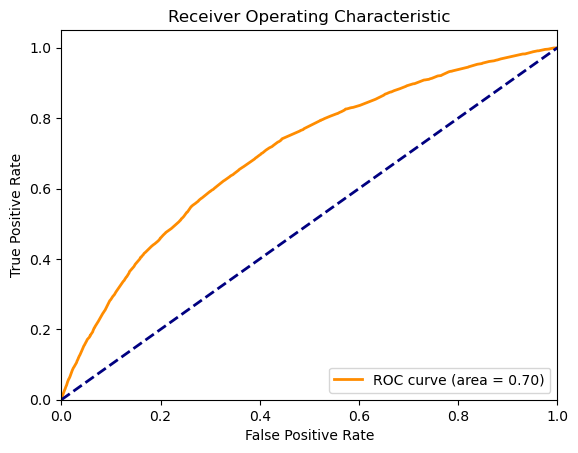

In [89]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Indice de Gini : stabilité des performances
On remarque bien que nos indices de Gini sur nos deux modèles sont identique, ce qui signifie que notre modèle est stable.

# Grille de Score :

A partir des résultats de la régression logistique, nous créons notre grille de score. La grille de score répertorie les probabilités de défaut prédites par le modèle pour l'ensemble de nos variables et de leur modalités. Nous calculons également pour chacune d'entre elles leur note et leur contribution dans le modèle dans nos deux data. Nous avons pu répertorier : 

- Les variables explicatives.
- Les modalités des variables explicatives.
- Les P-Values associées au test de Wald pour chaque classe.
- Le calcule de la note attribuée à chaque modalité.
- La contribution de la variable.
- Le taux de défaut de chaque classe.
- L'effectif de chaque classe.

### DF modelisation:

In [65]:
coefficients_dict = {
    'LTV_category': {'1': 0, '2': 0.2759, '3': 0.5287},
    'Age_category': {'1': 0, '2': 0.2648, '3': 0.4672, '4': 0.5480},
    'REGION_RATING_CLIENT_W_CITY_category': {'1': 0, '2': 0.5145, '3': 0.8646},
    'EXT_SOURCE_3_category': {'1': 0, '2': 0.6445, '3': 1.4096},
    'CODE_GENDER': {'0': 0, '1': 0.3310},
    'NAME_EDUCATION_TYPE': {'0': 0, '1': 0.5679}
}

dfs = []

for variable in df_fin.columns:
    modalities = df_fin[variable].unique()

    for modality in modalities:
        subset_data = df_fin[df_fin[variable] == modality]
        default_count = subset_data[subset_data['TARGET'] == 1].shape[0]
        healthy_count = subset_data[subset_data['TARGET'] == 0].shape[0]

        default_rate = default_count / healthy_count if healthy_count > 0 else 0
        modality_count = subset_data.shape[0]

        temp_df = pd.DataFrame({
            'Variable': [variable],
            'Modalité': [modality],
            'Effectif': [modality_count],
            'Taux de défaut': [default_rate],
            'P-value': [0]
        })

        dfs.append(temp_df)

results_table = pd.concat(dfs, ignore_index=True)

results_table = results_table[results_table['Variable'] != 'TARGET']

for idx, row in results_table.iterrows():
    variable = row['Variable']
    modality = str(int(row['Modalité'])) if pd.notnull(row['Modalité']) else None

    coefficient = coefficients_dict.get(variable, {}).get(modality, float('nan'))
    results_table.at[idx, 'Coefficient'] = coefficient

sum_diff = (results_table.groupby('Variable')['Coefficient'].max() - results_table.groupby('Variable')['Coefficient'].min()).sum()

ponderations = pd.DataFrame(index=results_table.index, columns=['Ponderation'])

for variable in results_table['Variable'].unique():
    max_beta = results_table.loc[results_table['Variable'] == variable, 'Coefficient'].max()
    min_beta = results_table.loc[results_table['Variable'] == variable, 'Coefficient'].min()

    results_table.loc[results_table['Variable'] == variable, 'Ponderation'] = (np.abs(max_beta - results_table.loc[results_table['Variable'] == variable, 'Coefficient']) / sum_diff) * 1000

results_table['Total_Effectif_per_Variable'] = results_table.groupby('Variable')['Effectif'].transform('sum')
results_table['r_j'] = results_table['Effectif'] / results_table['Total_Effectif_per_Variable']

results_table['mean_ponderation'] = results_table.groupby('Variable')['Ponderation'].transform('mean')

results_table['ponderation_diff_sq_rj'] = results_table['r_j'] * (results_table['Ponderation'] - results_table['mean_ponderation']) ** 2

sum_ponderation_diff_rj = results_table.groupby('Variable')['ponderation_diff_sq_rj'].transform('sum')

results_table['sqrt_sum_ponderation_diff_rj'] = sum_ponderation_diff_rj.apply(np.sqrt)

total_sqrt_sum_ponderation_diff_rj = results_table['sqrt_sum_ponderation_diff_rj'].sum()

results_table['contribution_rj'] = results_table['sqrt_sum_ponderation_diff_rj'] / total_sqrt_sum_ponderation_diff_rj
grille_score = results_table[['Variable', 'Modalité', "Effectif","r_j", "Taux de défaut","P-value","Ponderation",'contribution_rj']]
grille_score

,Variable,Modalité,Effectif,r_j,Taux de défaut,P-value,Ponderation,contribution_rj
0,EXT_SOURCE_3_category,1.0,105024,0.392263,0.041967,0,331.686197,0.110656
1,EXT_SOURCE_3_category,2.0,122826,0.458753,0.086763,0,180.032002,0.110656
2,EXT_SOURCE_3_category,3.0,39889,0.148985,0.191499,0,0.000000,0.110656
3,LTV_category,1.0,158039,0.590273,0.066563,0,124.405854,0.051391
4,LTV_category,2.0,53515,0.199877,0.088035,0,59.485152,0.051391
5,LTV_category,3.0,56185,0.209850,0.125253,0,0.000000,0.051391
6,CODE_GENDER,1.0,91448,0.341557,0.106235,0,0.000000,0.035715
7,CODE_GENDER,0.0,176291,0.658443,0.070858,0,77.886018,0.035715
8,NAME_EDUCATION_TYPE,1.0,202275,0.755493,0.092735,0,0.000000,0.061277
9,NAME_EDUCATION_TYPE,0.0,65464,0.244507,0.052764,0,133.629818,0.061277


### DF validation:

In [66]:
coefficients_dict = {
    'LTV_category': {'1': 0, '2': 0.4533, '3': 0.8571},
    'Age_category': {'1': 0, '2': 0.2258, '3': 0.3334, '4': 0.4645},
    'REGION_RATING_CLIENT_W_CITY_category': {'1': 0, '2': 0.5315, '3': 0.8886},
    'EXT_SOURCE_3_category': {'1': 0, '2': 0.6032, '3': 1.2752},
    'CODE_GENDER': {'0': 0, '1': 0.3827},
    'NAME_EDUCATION_TYPE': {'0': 0, '1': 0.4759}
}

dfs = []

for variable in df_fin_val.columns:
    modalities = df_fin_val[variable].unique()

    for modality in modalities:
        subset_data = df_fin_val[df_fin_val[variable] == modality]
        default_count = subset_data[subset_data['TARGET'] == 1].shape[0]
        healthy_count = subset_data[subset_data['TARGET'] == 0].shape[0]

        default_rate = default_count / healthy_count if healthy_count > 0 else 0
        modality_count = subset_data.shape[0]

        temp_df = pd.DataFrame({
            'Variable': [variable],
            'Modalité': [modality],
            'Effectif': [modality_count],
            'Taux de défaut': [default_rate],
            'P-value': [0]
        })

        dfs.append(temp_df)

results_table = pd.concat(dfs, ignore_index=True)

results_table = results_table[results_table['Variable'] != 'TARGET']

for idx, row in results_table.iterrows():
    variable = row['Variable']
    modality = str(int(row['Modalité'])) if pd.notnull(row['Modalité']) else None

    coefficient = coefficients_dict.get(variable, {}).get(modality, float('nan'))
    results_table.at[idx, 'Coefficient'] = coefficient

sum_diff = (results_table.groupby('Variable')['Coefficient'].max() - results_table.groupby('Variable')['Coefficient'].min()).sum()

ponderations = pd.DataFrame(index=results_table.index, columns=['Ponderation'])

for variable in results_table['Variable'].unique():
    max_beta = results_table.loc[results_table['Variable'] == variable, 'Coefficient'].max()
    min_beta = results_table.loc[results_table['Variable'] == variable, 'Coefficient'].min()

    results_table.loc[results_table['Variable'] == variable, 'Ponderation'] = (np.abs(max_beta - results_table.loc[results_table['Variable'] == variable, 'Coefficient']) / sum_diff) * 1000

results_table['Total_Effectif_per_Variable'] = results_table.groupby('Variable')['Effectif'].transform('sum')
results_table['r_j'] = results_table['Effectif'] / results_table['Total_Effectif_per_Variable']

results_table['mean_ponderation'] = results_table.groupby('Variable')['Ponderation'].transform('mean')

results_table['ponderation_diff_sq_rj'] = results_table['r_j'] * (results_table['Ponderation'] - results_table['mean_ponderation']) ** 2

sum_ponderation_diff_rj = results_table.groupby('Variable')['ponderation_diff_sq_rj'].transform('sum')

results_table['sqrt_sum_ponderation_diff_rj'] = sum_ponderation_diff_rj.apply(np.sqrt)

total_sqrt_sum_ponderation_diff_rj = results_table['sqrt_sum_ponderation_diff_rj'].sum()

results_table['contribution_rj'] = results_table['sqrt_sum_ponderation_diff_rj'] / total_sqrt_sum_ponderation_diff_rj
grille_score_val = results_table[['Variable', 'Modalité', "Effectif","r_j", "Taux de défaut","P-value","Ponderation",'contribution_rj']]
grille_score_val

,Variable,Modalité,Effectif,r_j,Taux de défaut,P-value,Ponderation,contribution_rj
0,EXT_SOURCE_3_category,1.0,12647,0.329658,0.039109,0,293.554328,0.107372
1,EXT_SOURCE_3_category,3.0,11473,0.299056,0.155737,0,0.000000,0.107372
2,EXT_SOURCE_3_category,2.0,14244,0.371286,0.076644,0,154.696133,0.107372
3,LTV_category,1.0,22502,0.586539,0.066547,0,197.306630,0.072694
4,LTV_category,2.0,14762,0.384788,0.109925,0,92.955801,0.072694
5,LTV_category,3.0,1100,0.028673,0.182796,0,0.000000,0.072694
6,CODE_GENDER,1.0,13035,0.339772,0.112012,0,0.000000,0.040652
7,CODE_GENDER,0.0,25329,0.660228,0.072990,0,88.098527,0.040652
8,NAME_EDUCATION_TYPE,1.0,29033,0.756777,0.094965,0,0.000000,0.050553
9,NAME_EDUCATION_TYPE,0.0,9331,0.243223,0.058777,0,109.553407,0.050553


Nous remarquons que les résultats de notre base et celle de validation sont très similaire, indiquant que chaque variable à un impact plus ou moins constant au fil du temps. 

L'interprétation est faite comme suit : la note 0 représente les clients les plus risqué (modalité les plus élevé), et la note 1000 les clients les plus sains. Plus la modalité est élevé, plus sa note est basse.

# Indice de stabilité :

In [67]:
variables = grille_score["Variable"].unique()

IS_per_variable = {}

for variable in variables:
    df_variable = grille_score[grille_score["Variable"] == variable]
    df_validation_variable = grille_score_val[grille_score_val["Variable"] == variable]

    diff = df_variable["r_j"] - df_validation_variable["r_j"]

    ln_ratio = np.log(df_variable["r_j"] / df_validation_variable["r_j"])

    product = diff * ln_ratio

    IS = np.sum(product)

    IS_per_variable[variable] = IS

for variable, IS in IS_per_variable.items():
    print(f"L'indice de stabilité (IS) pour la variable {variable} est : {IS}")

L'indice de stabilité (IS) pour la variable EXT_SOURCE_3_category est : 0.28220542522630576
L'indice de stabilité (IS) pour la variable LTV_category est : 0.48176111008260447
L'indice de stabilité (IS) pour la variable CODE_GENDER est : 1.4183176451840643e-05
L'indice de stabilité (IS) pour la variable NAME_EDUCATION_TYPE est : 8.940420726753015e-06
L'indice de stabilité (IS) pour la variable Age_category est : 0.11020474716277165
L'indice de stabilité (IS) pour la variable REGION_RATING_CLIENT_W_CITY_category est : 2.219438064042317


L'indice de stabilité nous donne une indication sur les  proportions de chaque modalité pour chaque variable par rapport à notre base de validation. Si cette indice est nul, cela signifie que la contribution observée sur les 9 ans et sur la base de validation sont égales, ce qui indique une stabilité du modèle. Si elle est positive, cela indique une surperformance par rapport aux attentes. Nos variables sont relativement stable dans le temps, avec des indice de stabilité relativement proche de 0, mise à part pour REGION_RATING_CLIENT_W_CITY_category qui reste tout de même raisonnable.

## Attribution des scores: DF modélisation

- Les grilles de scores terminées, notre but est maintenant de créer des classes homogènes de risque en regroupant nos individus en fonction de leur note finale. Les notes finales de chacun sont calculées en fonction des notes qui ont été attribué à chaque modalités de chaque variable.  De fait, en fonction des modalités des variables de chaque individus et de leur note associé, nous calculons la somme pour chacun d'entre eux, donnant leur note final. Une note proche de 0 indique un client très risqué tandis qu'une note de 1000 indique un client "sain".

Pour se faire, il faut respecter plusieurs contraintes règlementaires :
1. Homogénéité au sein de chaque classe
2. Hétérogénéité entre les classes
3. Eviter une concentration excessive au sein de chaque classe (max 30%)
4. Assurer une augmentation régulière des taux de défaut à mesure que l’on progresse d’une classe à l’autre

In [68]:
zeros_data = {col: [0] * 4 for col in df_fin.columns}
df_fin_temp = pd.concat([df_fin, pd.DataFrame(zeros_data)], ignore_index=True)
df_resultat_final = df_fin_temp.copy()
for variable in df_resultat_final.columns:
    df_temp = pd.merge(df_resultat_final[[variable]], grille_score[grille_score['Variable'] == variable],
                       left_on=variable, right_on='Modalité', how='left')

    df_temp.rename(columns={'Ponderation': f'Note_{variable}'}, inplace=True)

    df_resultat_final = pd.concat([df_resultat_final, df_temp[f'Note_{variable}']], axis=1)

note_columns = [col for col in df_resultat_final.columns if col.startswith('Note_')]
df_resultat_final['Note_Totale'] = df_resultat_final[note_columns].sum(axis=1)
df_resultat_final = df_resultat_final.iloc[:-4, :]
df_resultat_final.drop('Note_TARGET',axis=1)

,EXT_SOURCE_3_category,LTV_category,CODE_GENDER,NAME_EDUCATION_TYPE,Age_category,REGION_RATING_CLIENT_W_CITY_category,TARGET,Note_EXT_SOURCE_3_category,Note_LTV_category,Note_CODE_GENDER,Note_NAME_EDUCATION_TYPE,Note_Age_category,Note_REGION_RATING_CLIENT_W_CITY_category,Note_Totale
0,1.0,1.0,1,1,3.0,3.0,0,331.686197,124.405854,0.000000,0.000000,19.012659,0.000000,475.104711
1,2.0,1.0,0,0,3.0,3.0,0,180.032002,124.405854,77.886018,133.629818,19.012659,0.000000,534.966351
2,2.0,2.0,0,1,4.0,2.0,0,180.032002,59.485152,77.886018,0.000000,0.000000,82.380347,399.783519
3,1.0,2.0,0,1,3.0,1.0,0,331.686197,59.485152,77.886018,0.000000,19.012659,203.444868,691.514895
4,2.0,1.0,0,1,2.0,2.0,0,180.032002,124.405854,77.886018,0.000000,66.638430,82.380347,531.342651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267734,1.0,1.0,1,1,1.0,2.0,0,331.686197,124.405854,0.000000,0.000000,128.947245,82.380347,667.419643
267735,1.0,1.0,0,1,2.0,2.0,0,331.686197,124.405854,77.886018,0.000000,66.638430,82.380347,682.996847
267736,1.0,1.0,1,1,1.0,2.0,0,331.686197,124.405854,0.000000,0.000000,128.947245,82.380347,667.419643
267737,1.0,1.0,1,1,4.0,3.0,0,331.686197,124.405854,0.000000,0.000000,0.000000,0.000000,456.092051


## Attribution des scores : DF validation

In [69]:
zeros_data = {col: [0] * 4 for col in df_fin_val.columns}
df_fin_temp = pd.concat([df_fin_val, pd.DataFrame(zeros_data)], ignore_index=True)
df_resultat_final_val = df_fin_temp.copy()
for variable in df_resultat_final_val.columns:
    df_temp = pd.merge(df_resultat_final_val[[variable]], grille_score_val[grille_score_val['Variable'] == variable],
                       left_on=variable, right_on='Modalité', how='left')

    df_temp.rename(columns={'Ponderation': f'Note_{variable}'}, inplace=True)

    df_resultat_final_val = pd.concat([df_resultat_final_val, df_temp[f'Note_{variable}']], axis=1)

note_columns = [col for col in df_resultat_final_val.columns if col.startswith('Note_')]
df_resultat_final_val['Note_Totale'] = df_resultat_final_val[note_columns].sum(axis=1)
df_resultat_final_val = df_resultat_final_val.iloc[:-4, :]
df_resultat_final_val.drop('Note_TARGET',axis=1)

,EXT_SOURCE_3_category,LTV_category,CODE_GENDER,NAME_EDUCATION_TYPE,Age_category,REGION_RATING_CLIENT_W_CITY_category,TARGET,Note_EXT_SOURCE_3_category,Note_LTV_category,Note_CODE_GENDER,Note_NAME_EDUCATION_TYPE,Note_Age_category,Note_REGION_RATING_CLIENT_W_CITY_category,Note_Totale
0,1.0,1.0,1,1,4.0,2.0,0,293.554328,197.306630,0.000000,0.000000,0.000000,82.205341,573.066298
1,3.0,2.0,1,1,1.0,2.0,0,0.000000,92.955801,0.000000,0.000000,106.929098,82.205341,282.090239
2,1.0,1.0,1,1,3.0,2.0,0,293.554328,197.306630,0.000000,0.000000,30.179558,82.205341,603.245856
3,2.0,1.0,0,1,2.0,2.0,0,154.696133,197.306630,88.098527,0.000000,54.949355,82.205341,577.255985
4,1.0,1.0,1,0,2.0,2.0,0,293.554328,197.306630,0.000000,109.553407,54.949355,82.205341,737.569061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38359,1.0,1.0,0,1,2.0,3.0,0,293.554328,197.306630,88.098527,0.000000,54.949355,0.000000,633.908840
38360,1.0,2.0,0,1,2.0,2.0,0,293.554328,92.955801,88.098527,0.000000,54.949355,82.205341,611.763352
38361,2.0,2.0,0,1,2.0,1.0,0,154.696133,92.955801,88.098527,0.000000,54.949355,204.558011,595.257827
38362,3.0,2.0,1,1,1.0,3.0,0,0.000000,92.955801,0.000000,0.000000,106.929098,0.000000,199.884899


# Densité conditionnelle:

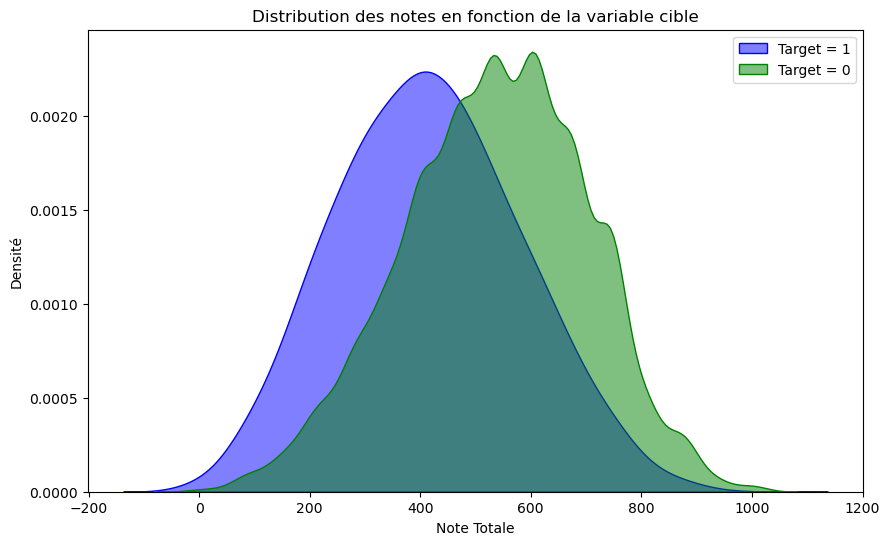

In [70]:
notes_target_1 = df_resultat_final[df_resultat_final['TARGET']==1]['Note_Totale']
notes_target_0 = df_resultat_final[df_resultat_final['TARGET']==0]['Note_Totale']

plt.figure(figsize=(10, 6))
sns.kdeplot(notes_target_1, shade=True, color='blue', label='Target = 1', alpha=0.5, bw_adjust= 2)  # Ajuster bw_adjust pour lisser
sns.kdeplot(notes_target_0, shade=True, color='green', label='Target = 0', alpha=0.5, bw_adjust=2)  # Ajuster bw_adjust pour lisser
plt.xlabel('Note Totale')
plt.ylabel('Densité')
plt.title('Distribution des notes en fonction de la variable cible')
plt.legend()
plt.show()

# Classes de risque :

In [71]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans.fit(df_resultat_final[['Note_Totale']])

inertia = kmeans.inertia_
print("Inertie intra-cluster :", inertia)

centroids = kmeans.cluster_centers_

inter_cluster_distance = 0
n_clusters = len(centroids)
for i in range(n_clusters):
    for j in range(i + 1, n_clusters):
        inter_cluster_distance += np.linalg.norm(centroids[i] - centroids[j])

inter_cluster_distance /= (n_clusters * (n_clusters - 1) / 2)
print("Inertie inter-cluster :", inter_cluster_distance)

Inertie intra-cluster : 513030184.3722423
Inertie inter-cluster : 276.5906730282319


In [72]:
kmeans = KMeans(n_clusters=5, n_init='auto')
df_resultat_final['cluster'] = kmeans.fit_predict(df_resultat_final[["Note_Totale"]])
df_resultat_final

,EXT_SOURCE_3_category,LTV_category,CODE_GENDER,NAME_EDUCATION_TYPE,Age_category,REGION_RATING_CLIENT_W_CITY_category,TARGET,Note_EXT_SOURCE_3_category,Note_LTV_category,Note_CODE_GENDER,Note_NAME_EDUCATION_TYPE,Note_Age_category,Note_REGION_RATING_CLIENT_W_CITY_category,Note_TARGET,Note_Totale,cluster
0,1.0,1.0,1,1,3.0,3.0,0,331.686197,124.405854,0.000000,0.000000,19.012659,0.000000,NaN,475.104711,2
1,2.0,1.0,0,0,3.0,3.0,0,180.032002,124.405854,77.886018,133.629818,19.012659,0.000000,NaN,534.966351,2
2,2.0,2.0,0,1,4.0,2.0,0,180.032002,59.485152,77.886018,0.000000,0.000000,82.380347,NaN,399.783519,4
3,1.0,2.0,0,1,3.0,1.0,0,331.686197,59.485152,77.886018,0.000000,19.012659,203.444868,NaN,691.514895,3
4,2.0,1.0,0,1,2.0,2.0,0,180.032002,124.405854,77.886018,0.000000,66.638430,82.380347,NaN,531.342651,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267734,1.0,1.0,1,1,1.0,2.0,0,331.686197,124.405854,0.000000,0.000000,128.947245,82.380347,NaN,667.419643,3
267735,1.0,1.0,0,1,2.0,2.0,0,331.686197,124.405854,77.886018,0.000000,66.638430,82.380347,NaN,682.996847,3
267736,1.0,1.0,1,1,1.0,2.0,0,331.686197,124.405854,0.000000,0.000000,128.947245,82.380347,NaN,667.419643,3
267737,1.0,1.0,1,1,4.0,3.0,0,331.686197,124.405854,0.000000,0.000000,0.000000,0.000000,NaN,456.092051,2


In [73]:
cluster_target_counts = df_resultat_final[df_resultat_final['TARGET'] == 1].groupby('cluster')['TARGET'].count()
cluster_target_counts

cluster
0     883
1    5695
2    5191
3    2819
4    5859
Name: TARGET, dtype: int64

La méthode KMeans a été choisie ici car elle nous permettait de respecter au maximums nos hypothèses d'homogénéité au sein de chaque classe et d'hétérogénéité entre les classes. De fait, 5 classes ont été crée : 
1. La classe de risque très élevée
2. La classe de risque élevé
3. La classe de risque moyenne
4. La classe de risque faible
5. La classe de risque très faible

Ici, on observe un répartition de l'effectif proportionnelle, avec aucune classe qui ne dépasse 30% de l’effectif total. De plus, l'hypothèse de monotonie des taux de défaut à été respecté. En effet, plus on va de la catégorie de risque élevé à très faible, plus le taux de défaut diminue, que ce soit sur notre data de base ou sur notre data de validation.

## Analyse de classe: df modélisation

In [74]:
for i in df_resultat_final['cluster'].unique():
    min_note = df_resultat_final[df_resultat_final['cluster'] == i]['Note_Totale'].min()
    max_note = df_resultat_final[df_resultat_final['cluster'] == i]['Note_Totale'].max()
    print(f'Cluster {i}: Min Note_Totale = {min_note:.2f}, Max Note_Totale = {max_note:.2f}')

Cluster 2: Min Note_Totale = 446.35, Max Note_Totale = 570.45
Cluster 4: Min Note_Totale = 304.44, Max Note_Totale = 442.96
Cluster 3: Min Note_Totale = 571.91, Max Note_Totale = 708.15
Cluster 0: Min Note_Totale = 714.72, Max Note_Totale = 1000.00
Cluster 1: Min Note_Totale = 0.00, Max Note_Totale = 303.68


In [75]:
Risque_tres_eleve = [0.00, 294.51]
Risque_eleve = [300.34, 439.79]
Risque_moyen = [442.61, 567.01]
Risque_faible = [570.45, 705.54]
Risque_tres_faible = [708.15, 1000.00]

bins = [-float("inf"), 294.51, 439.79, 567.01, 705.54, float("inf")]
labels = ['Risque_très_élevé', 'Risque_élevé', 'Risque_moyen', 'Risque_faible', 'Risque_très_faible']

df_resultat_final['categorie_risque'] = pd.cut(df_resultat_final['Note_Totale'], bins=bins, labels=labels, include_lowest=True)

cluster_stats = df_resultat_final.groupby('categorie_risque')['TARGET'].agg(['count', 'sum'])
cluster_stats['sains'] = cluster_stats['count'] - cluster_stats['sum']
cluster_stats.columns = ['total', 'defaut', 'sains']
cluster_stats['taux_defaut'] = cluster_stats['defaut'] / cluster_stats['sains']
cluster_stats

,total,defaut,sains,taux_defaut
categorie_risque,,,,
Risque_très_élevé,27107,5351,21756,0.245955
Risque_élevé,53267,6190,47077,0.131487
Risque_moyen,75295,5112,70183,0.072838
Risque_faible,73870,2898,70972,0.040833
Risque_très_faible,38200,896,37304,0.024019


## Analyse de classe: df validation

In [76]:
Risque_tres_eleve = [0.00, 294.51]
Risque_eleve = [300.34, 439.79]
Risque_moyen = [442.61, 567.01]
Risque_faible = [570.45, 705.54]
Risque_tres_faible = [708.15, 1000.00]

bins = [-float("inf"), 294.51, 439.79, 567.01, 705.54, float("inf")]
labels = ['Risque_très_élevé', 'Risque_élevé', 'Risque_moyen', 'Risque_faible', 'Risque_très_faible']

df_resultat_final_val['categorie_risque'] = pd.cut(df_resultat_final_val['Note_Totale'], bins=bins, labels=labels, include_lowest=True)

cluster_stats = df_resultat_final_val.groupby('categorie_risque')['TARGET'].agg(['count', 'sum'])
cluster_stats['sains'] = cluster_stats['count'] - cluster_stats['sum']
cluster_stats.columns = ['total', 'defaut', 'sains']
cluster_stats['taux_defaut'] = cluster_stats['defaut'] / cluster_stats['sains']
cluster_stats

,total,defaut,sains,taux_defaut
categorie_risque,,,,
Risque_très_élevé,4043,798,3245,0.245917
Risque_élevé,8365,965,7400,0.130405
Risque_moyen,9606,696,8910,0.078114
Risque_faible,10546,454,10092,0.044986
Risque_très_faible,5804,123,5681,0.021651


A partir des notes finales minimales et maximale de chaque cluster, on attribue une classe à chacun de nos individus de la base de validation pour tester de la fiabilité de ces derniere. On voit ici que les taux de défaut des classes de la base de validation sont extrêmements similaires à notre base de référence, ce qui atteste de la fiabilité de nos classes et de nos résultas. 

## Stabilité temporelle des classes :

In [77]:
dg['date_mensuelle'] = pd.to_datetime(dg['date_mensuelle'])

df_resultat_final['date_annee'] = dg['date_mensuelle'][:267739].dt.year

In [78]:
grouped_data = df_resultat_final.groupby(['date_annee', 'categorie_risque'])

defaut_sains_par_annee = grouped_data['TARGET'].value_counts().unstack().fillna(0)

defaut_sains_par_annee = grouped_data['TARGET'].value_counts().unstack().fillna(0)

defaut_sains_par_annee['taux_defaut'] = defaut_sains_par_annee[1] / (defaut_sains_par_annee[0])

defaut_sains_par_annee.reset_index().pivot(index='date_annee', columns='categorie_risque', values='taux_defaut').T

date_annee,2013,2014,2015,2016,2017,2018,2019
categorie_risque,,,,,,,
Risque_très_élevé,0.248473,0.271492,0.248166,0.252218,0.257951,0.232868,0.212333
Risque_élevé,0.133727,0.130556,0.139490,0.137363,0.133353,0.139331,0.106386
Risque_moyen,0.076670,0.072032,0.075677,0.075268,0.077008,0.075110,0.058241
Risque_faible,0.043174,0.045195,0.039067,0.039656,0.039216,0.042599,0.036905
Risque_très_faible,0.021834,0.024874,0.025547,0.025370,0.024331,0.025467,0.020677


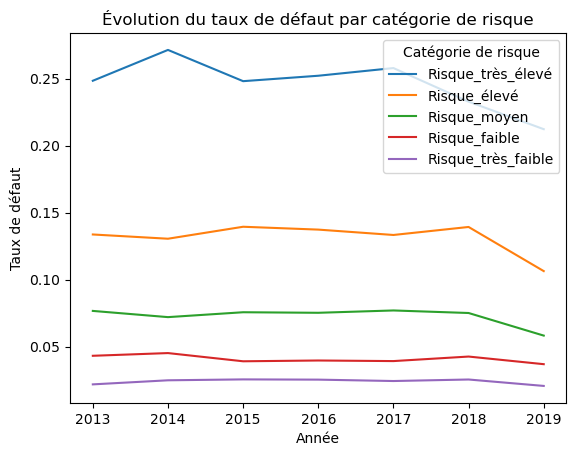

In [79]:
defaut_sains_par_annee.reset_index().pivot(index='date_annee', columns='categorie_risque', values='taux_defaut').plot()
plt.title('Évolution du taux de défaut par catégorie de risque')
plt.xlabel('Année')
plt.ylabel('Taux de défaut')
plt.legend(title='Catégorie de risque')
plt.show()

Le graphique ce-dessus nous montre bien que chaque catégorie de risque est hétérogène et qu'aucun croisement n'est notable. Plus la le graphe est bas, plus le taux de défaut de la classe est bas et plus le risque du client est faible

# Calibrage : MOC C:

In [80]:
X_test = X_test.reset_index(drop=False)
df_resultat_final = df_resultat_final.reset_index(drop=False)

In [81]:
moc = df_resultat_final[df_resultat_final['index'].isin(X_test['index'].tolist())]

In [82]:
classes_uniques = moc['categorie_risque'].unique()
sous_ensembles_par_classe = {classe: moc[moc['categorie_risque'] == classe] for classe in classes_uniques}

n_echantillons = 500
echantillons_aleatoires_par_classe = {}

for classe, sous_ensemble in sous_ensembles_par_classe.items():
    echantillons_aleatoires = [sous_ensemble.sample(n=len(sous_ensemble), replace=True) for _ in range(n_echantillons)]
    echantillons_aleatoires_par_classe[classe] = echantillons_aleatoires

echantillons_concatenes_par_classe = {}

for classe, echantillons in echantillons_aleatoires_par_classe.items():
    echantillons_concatenes_par_classe[classe] = pd.concat(echantillons)

In [83]:
echantillons_concatenes_par_classe = {}

for classe, echantillons in echantillons_aleatoires_par_classe.items():
    echantillons_concatenes_par_classe[classe] = pd.concat(echantillons)

def calculer_lra_moyen_par_echantillons(echantillons_par_classe):
    lra_moyen_par_classe_echantillons = {}

    for classe, echantillons in echantillons_par_classe.items():
        lra_moyen_echantillons = []
        for echantillon in echantillons:
            lra_par_annee = []
            for annee in echantillons_concatenes_par_classe[classe]['date_annee'].unique():
                sous_ensemble_annee = echantillon[echantillon['date_annee'] == annee]
                sum_defaults_annee = sous_ensemble_annee['TARGET'].sum()
                sum_non_defaults_start = len(sous_ensemble_annee) - sum_defaults_annee
                if sum_non_defaults_start == 0:
                    lra_annee = 0
                else:
                    lra_annee = sum_defaults_annee / sum_non_defaults_start
                lra_par_annee.append(lra_annee)
            lra_moyen_echantillons.append(np.mean(lra_par_annee))
        lra_moyen_par_classe_echantillons[classe] = lra_moyen_echantillons

    return lra_moyen_par_classe_echantillons

lra_moyen_par_classe_echantillons = calculer_lra_moyen_par_echantillons(echantillons_aleatoires_par_classe)

In [84]:
def calculer_moc(lra_bootstrapped_par_classe, lra_moyen_par_classe_echantillons):
    moc_par_classe = {}

    for classe in lra_bootstrapped_par_classe.keys():
        lra_bootstrapped = lra_bootstrapped_par_classe[classe]
        lra_moyen = lra_moyen_par_classe_echantillons[classe]

        percentile_90 = np.percentile(lra_bootstrapped, 90)

        difference = percentile_90 - np.mean(lra_moyen)

        moc_par_classe[classe] = difference

    return moc_par_classe

moc_par_classe = calculer_moc(lra_moyen_par_classe_echantillons, lra_moyen_par_classe_echantillons)
moc_par_classe

{'Risque_faible': 0.0022055051760137903,
 'Risque_élevé': 0.005224211494005815,
 'Risque_moyen': 0.003096867076663498,
 'Risque_très_faible': 0.002253879219919805,
 'Risque_très_élevé': 0.009707810866305788}